# Variational Autoencoder (VAE)

In this jupyter notebook we implement a [variational autoencoder](https://en.wikipedia.org/wiki/Variational_autoencoder) which allows to generate data from the training data distribution. It is, therefore a [generative model](https://en.wikipedia.org/wiki/Generative_model).
First we import all the needed packages.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Loading the Training Data

Here we will use the (balanced) extended MNIST (EMNIST) dataset which contains 47 different characters.
Below you see a random choice of training examples.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.0,), (1,)),
                                ])
mb_size = 100
#training_data=torchvision.datasets.MNIST("./data/MNIST","balanced", download=True, transform=transform)
training_data = torchvision.datasets.EMNIST(
    "./data/EMNIST", "balanced", download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size=mb_size,
                                          shuffle=True,
                                          num_workers=2)

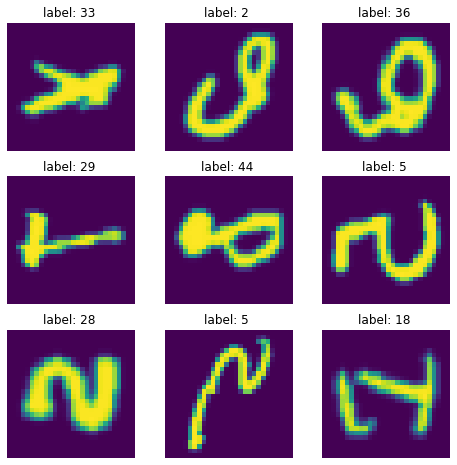

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("label: {} ".format(label))
    plt.axis("off")
    plt.imshow(img.squeeze(0))
plt.show()

# Definition of the Variational Autoencoder

A Variational Autoencoder consists (like an autoencoder) of an encoder and a decoder: The encoder maps the input $x_i$ to the latent space variable $z_i$ and the decoder maps the latent space variable back to the (estimated) input space variable $\hat{x_i}$.
While an autoencoder does not enforce any structure in the latent space representation the variational autoencoder enforces a structure in the latent space. This structure allows later to draw meaningful latent space representations and decode them.
, therefore, generating new samples from the approximated probability distribution $p(X)$.

The encoder maps the training  examples $x_i$ which follow a distribution $p(X=x_i)$ (i.e. $X \sim p(X)$) to a latent space distribution $p_{\theta}(Z=z_i|X=x_i)$ where the encoder outputs the parameters $\theta$ of this distribution.
Typically, one assumes that $p_{\theta}(Z|X)$ is a Gaussian/Normal distribution and, therefore, has a mean and variance, (i.e.  $\theta=(\mu, \sigma^2)$). Other choices of probability distributions woule be possible.
In the following we also do not allow the mean and variance of $p_{\theta}(Z|X)$ to take arbitrary values, but we try to bring it close to having zero mean and variance one in order to structure the latent space. This is done via the loss function later on.

In the Variational Autoencoder, we obtain a random sample $z_i \sim p_{\theta=(\mu, \sigma)}(Z|X)$ using the formula $z_i=\mu+\sigma n_i$, where the Gaussian random number $n_i \sim N(\mu=0, \sigma=1)$ is used.
This random sample is then decoded using the decoder.  
Note that drawing $z_i$ like this is called the "reparametrization trick" which allows backpropagation (in contrast to directly drwaing $z_i \sim N(\mu, \sigma)$).

The decoder now has the task of outputing samples $\hat{x}_i \sim p(X|Z=z_i)$ where $\hat{x}_i$ should be as close as possible to the training example $x_i$.

We, therefore, prescribe a reconstruction loss (for example the mean squared error or binary cross entropy) which ensures that the decoding is successful.
For the reconstruction loss we can use the mean squared error or the binary cross entropy (if the variables $x_i$ lie elementwise within the interval \[0,1\])
The [Kullback Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL divergence) between $p_{\theta}(Z=z_i|X=x_i)$ and the standard normal distribution $\mathcal{N}(0,1)$ is added to enforce a structure in the latent space (for two Gaussian distributions the KL divergence takes the form shown below (see also Wikipedia).

Below we use two neural nets as a decoder and an encoder making use of their property as universal function approximators.
The architecture of the neural nets (e.g. deepness of the networks and the application of convolutional layers) influences the convergence rate a lot, so feel free to build a better architecture.


In [4]:
class Decoder(nn.Module):
    def __init__(self, input_size, dimensionality_latent_distribution):
        super(Decoder, self).__init__()
        self.dimensionality_latent_distribution = dimensionality_latent_distribution
        self.input_size = input_size

        self.fc1_generator = nn.Linear(
            self.dimensionality_latent_distribution, (input_size-4)**2)
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=1, out_channels=20, kernel_size=3, stride=1)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=20, out_channels=2, kernel_size=3, stride=1)
        self.fc2_generator = nn.Linear(2*input_size**2, input_size**2)
        self.fc3_generator = nn.Linear(input_size**2, input_size**2)

    def generate(self, samples_latent):
        res = self.fc1_generator(samples_latent.unsqueeze(1))
        res = torch.reshape(
            res, (res.shape[0], res.shape[1], self.input_size-4, self.input_size-4))
        res = F.leaky_relu(self.deconv1(res), 0.2)
        res = F.leaky_relu(self.deconv2(res), 0.2)
        res = torch.flatten(res, 1)
        res = F.leaky_relu(self.fc2_generator(res), 0.2)
        res = self.fc3_generator(res)
        res = torch.reshape(
            res, (res.shape[0], self.input_size, self.input_size))
        return torch.sigmoid(res)


class Encoder(nn.Module):
    def __init__(self, input_size, dimensionality_latent_distribution):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.dimensionality_latent_distribution = dimensionality_latent_distribution
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=15, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(
            in_channels=15, out_channels=5, kernel_size=3, stride=1)
        self.fc_1 = nn.Linear(5*(input_size-4)**2, 100)
        self.hidden = nn.Linear(100, 100)
        self.fc_mean = nn.Linear(100, self.dimensionality_latent_distribution)
        self.fc_std = nn.Linear(100, self.dimensionality_latent_distribution)

    def encode(self, x):
        # p(z|x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.leaky_relu(self.fc_1(x), 0.2)
        x = F.leaky_relu(self.hidden(x), 0.2)

        # do not apply a non-linear function here, so that the mean can take positive and negative values
        means = self.fc_mean(x)
        # exponentiating will bring it to [0,...infty], negative sigma are not allowed
        log_stds = self.fc_std(x)
        # Sample z ~ q(z|x) making use of the reparametrization trick for enabling backpropagation
        samples_latent = (means+torch.exp(log_stds)*torch.normal(mean=0,
                          std=1, size=(mb_size, self.dimensionality_latent_distribution)))
        return means, torch.exp(log_stds), samples_latent


class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(VariationalAutoencoder, self).__init__()
        self.dimensionality_latent_distribution = 12
        self.input_size = input_size
        self.decoder = Decoder(
            input_size, self.dimensionality_latent_distribution)
        self.encoder = Encoder(
            input_size, self.dimensionality_latent_distribution)

    def forward(self, x):
        # call encoder
        means, stds, samples_latent = self.encoder.encode(x)

        # call decoder
        reconstruction = self.decoder.generate(samples_latent).unsqueeze(1)
        return reconstruction, means, stds, samples_latent


myVAE = VariationalAutoencoder(input_size=28)

mse = nn.MSELoss(reduction="sum")

optimizer = optim.Adam(myVAE.parameters(), lr=0.001)

In [42]:
total_number_of_parameters = sum(
    dict((p.data_ptr(), p.numel()) for p in myVAE.parameters()).values())
print("Total numer of parameters: ", total_number_of_parameters)

decoder_number_of_parameters = sum(
    dict((p.data_ptr(), p.numel()) for p in myVAE.decoder.parameters()).values())
print("Number of parameters in the generator: ", decoder_number_of_parameters)

encoder_number_of_parameters = sum(
    dict((p.data_ptr(), p.numel()) for p in myVAE.encoder.parameters()).values())
print("Numer of parameters in the encoder", encoder_number_of_parameters)

Total numer of parameters:  2155040
Number of parameters in the generator:  1853586
Numer of parameters in the encoder 301454


## Training the Model

epoch 1
Reconstruction loss 542.9883422851562, Kullback Leibler divergence 0.054149314761161804


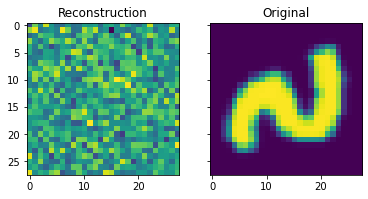

Reconstruction loss 536.2838134765625, Kullback Leibler divergence 0.029588017612695694
Reconstruction loss 522.9236450195312, Kullback Leibler divergence 0.019423794001340866
Reconstruction loss 503.8511657714844, Kullback Leibler divergence 0.04459356889128685
Reconstruction loss 474.228271484375, Kullback Leibler divergence 0.12924465537071228
Reconstruction loss 440.0670166015625, Kullback Leibler divergence 0.33930933475494385
Reconstruction loss 398.8264465332031, Kullback Leibler divergence 0.8397192358970642
Reconstruction loss 366.427490234375, Kullback Leibler divergence 2.09989857673645
Reconstruction loss 336.127197265625, Kullback Leibler divergence 5.026586532592773
Reconstruction loss 315.091552734375, Kullback Leibler divergence 4.737219333648682
Reconstruction loss 316.5718688964844, Kullback Leibler divergence 3.095000982284546


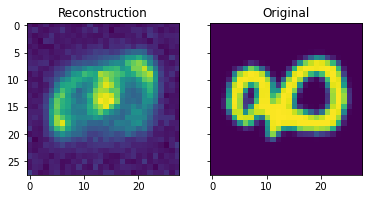

Reconstruction loss 303.6253662109375, Kullback Leibler divergence 1.5707528591156006
Reconstruction loss 321.9407958984375, Kullback Leibler divergence 0.7355197668075562
Reconstruction loss 287.8748474121094, Kullback Leibler divergence 0.3215511739253998
Reconstruction loss 297.4790344238281, Kullback Leibler divergence 0.15229490399360657
Reconstruction loss 288.365966796875, Kullback Leibler divergence 0.08823341131210327
Reconstruction loss 285.4798583984375, Kullback Leibler divergence 0.06980269402265549
Reconstruction loss 295.36444091796875, Kullback Leibler divergence 0.06574294716119766
Reconstruction loss 285.9637451171875, Kullback Leibler divergence 0.0663260892033577
Reconstruction loss 285.129638671875, Kullback Leibler divergence 0.06794355809688568
Reconstruction loss 285.0079650878906, Kullback Leibler divergence 0.06938305497169495


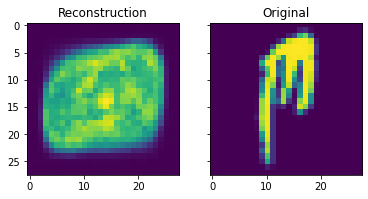

Reconstruction loss 280.5172424316406, Kullback Leibler divergence 0.06957785785198212
Reconstruction loss 281.3152770996094, Kullback Leibler divergence 0.06890098750591278
Reconstruction loss 286.4728088378906, Kullback Leibler divergence 0.06753043085336685
Reconstruction loss 281.2838134765625, Kullback Leibler divergence 0.06621989607810974
Reconstruction loss 284.26971435546875, Kullback Leibler divergence 0.06412200629711151
Reconstruction loss 286.4914855957031, Kullback Leibler divergence 0.0623648501932621
Reconstruction loss 279.34307861328125, Kullback Leibler divergence 0.06150399520993233
Reconstruction loss 283.94366455078125, Kullback Leibler divergence 0.05988721922039986
Reconstruction loss 285.5838623046875, Kullback Leibler divergence 0.05816375091671944
Reconstruction loss 279.2334899902344, Kullback Leibler divergence 0.05662451684474945


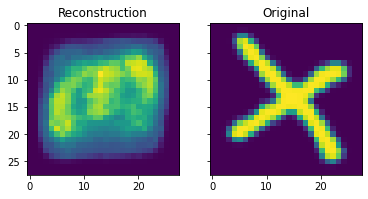

Reconstruction loss 281.0194091796875, Kullback Leibler divergence 0.05548078939318657
Reconstruction loss 283.0794982910156, Kullback Leibler divergence 0.05454220250248909
Reconstruction loss 275.2377014160156, Kullback Leibler divergence 0.05325637385249138
Reconstruction loss 284.3289489746094, Kullback Leibler divergence 0.05217543616890907
Reconstruction loss 287.561767578125, Kullback Leibler divergence 0.051491718739271164
Reconstruction loss 282.78045654296875, Kullback Leibler divergence 0.049123503267765045
Reconstruction loss 277.84588623046875, Kullback Leibler divergence 0.04847094044089317
Reconstruction loss 279.6563415527344, Kullback Leibler divergence 0.0475795604288578
Reconstruction loss 275.89288330078125, Kullback Leibler divergence 0.046209078282117844
Reconstruction loss 273.7617492675781, Kullback Leibler divergence 0.04340316727757454


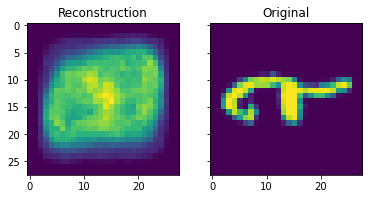

Reconstruction loss 278.50579833984375, Kullback Leibler divergence 0.043155767023563385
Reconstruction loss 276.5376281738281, Kullback Leibler divergence 0.04009486362338066
Reconstruction loss 275.0106201171875, Kullback Leibler divergence 0.03984299674630165
Reconstruction loss 280.24945068359375, Kullback Leibler divergence 0.03865168243646622
Reconstruction loss 289.47796630859375, Kullback Leibler divergence 0.03976006433367729
Reconstruction loss 269.7137145996094, Kullback Leibler divergence 0.03660065308213234
Reconstruction loss 270.1824951171875, Kullback Leibler divergence 0.03633829206228256
Reconstruction loss 282.2393798828125, Kullback Leibler divergence 0.039920624345541
Reconstruction loss 281.0438232421875, Kullback Leibler divergence 0.04099864140152931
Reconstruction loss 276.4715270996094, Kullback Leibler divergence 0.0419367253780365


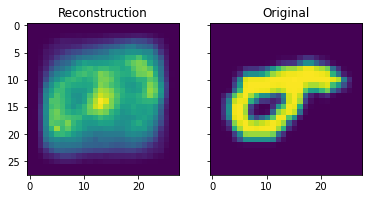

Reconstruction loss 284.6276550292969, Kullback Leibler divergence 0.04555666074156761
Reconstruction loss 282.92938232421875, Kullback Leibler divergence 0.05067402496933937
Reconstruction loss 276.5624084472656, Kullback Leibler divergence 0.04507795721292496
Reconstruction loss 282.1509704589844, Kullback Leibler divergence 0.05830230191349983
Reconstruction loss 281.77642822265625, Kullback Leibler divergence 0.06895442306995392
Reconstruction loss 277.3980712890625, Kullback Leibler divergence 0.06638112664222717
Reconstruction loss 281.40350341796875, Kullback Leibler divergence 0.0671495646238327
Reconstruction loss 283.0067138671875, Kullback Leibler divergence 0.0803336426615715
Reconstruction loss 281.20489501953125, Kullback Leibler divergence 0.09566757827997208
Reconstruction loss 270.7610168457031, Kullback Leibler divergence 0.09696346521377563


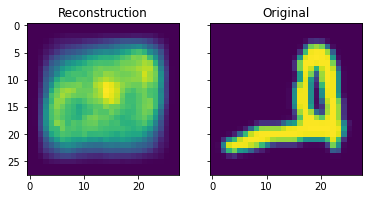

Reconstruction loss 283.20819091796875, Kullback Leibler divergence 0.12130668759346008
Reconstruction loss 276.05035400390625, Kullback Leibler divergence 0.11822152137756348
Reconstruction loss 279.3558349609375, Kullback Leibler divergence 0.2042192816734314
Reconstruction loss 274.11639404296875, Kullback Leibler divergence 0.21799787878990173
Reconstruction loss 277.59698486328125, Kullback Leibler divergence 0.3004351556301117
Reconstruction loss 271.9813232421875, Kullback Leibler divergence 0.4052107334136963
Reconstruction loss 277.91180419921875, Kullback Leibler divergence 0.46486297249794006
Reconstruction loss 268.7890625, Kullback Leibler divergence 0.5211609601974487
Reconstruction loss 274.4215087890625, Kullback Leibler divergence 0.5231131911277771
Reconstruction loss 285.1702880859375, Kullback Leibler divergence 0.5861241817474365


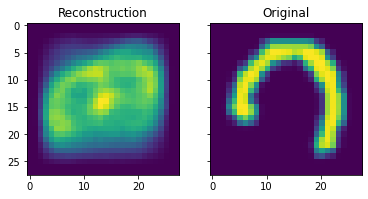

Reconstruction loss 285.3588562011719, Kullback Leibler divergence 0.7073811292648315
Reconstruction loss 286.40216064453125, Kullback Leibler divergence 0.6100056171417236
Reconstruction loss 275.8385009765625, Kullback Leibler divergence 0.8374443650245667
Reconstruction loss 283.3314514160156, Kullback Leibler divergence 0.8635134100914001
Reconstruction loss 271.77972412109375, Kullback Leibler divergence 0.9108831286430359
Reconstruction loss 276.0493469238281, Kullback Leibler divergence 1.0738627910614014
Reconstruction loss 277.593017578125, Kullback Leibler divergence 0.9748777747154236
Reconstruction loss 276.14874267578125, Kullback Leibler divergence 0.9807007312774658
Reconstruction loss 278.4668273925781, Kullback Leibler divergence 0.9835315942764282
Reconstruction loss 276.415771484375, Kullback Leibler divergence 1.1473872661590576


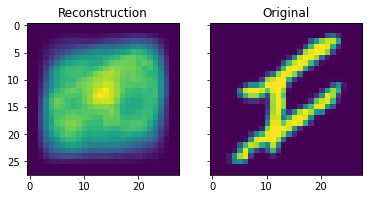

Reconstruction loss 276.0350646972656, Kullback Leibler divergence 1.000808596611023
Reconstruction loss 268.94158935546875, Kullback Leibler divergence 0.7984667420387268
Reconstruction loss 279.87518310546875, Kullback Leibler divergence 0.624347448348999
Reconstruction loss 266.0184631347656, Kullback Leibler divergence 0.7420205473899841
Reconstruction loss 270.30389404296875, Kullback Leibler divergence 0.6258230209350586
Reconstruction loss 280.8682861328125, Kullback Leibler divergence 0.6219055652618408
Reconstruction loss 275.98846435546875, Kullback Leibler divergence 0.6892478466033936
Reconstruction loss 278.3252258300781, Kullback Leibler divergence 0.9502378702163696
Reconstruction loss 275.7677001953125, Kullback Leibler divergence 1.0490753650665283
Reconstruction loss 277.7005310058594, Kullback Leibler divergence 1.0935313701629639


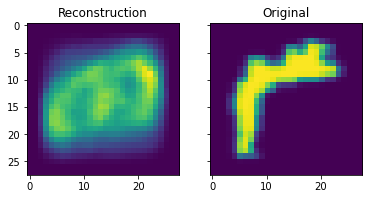

Reconstruction loss 271.8837890625, Kullback Leibler divergence 1.186742901802063
Reconstruction loss 274.1006774902344, Kullback Leibler divergence 1.3586534261703491
Reconstruction loss 280.7695617675781, Kullback Leibler divergence 1.8827095031738281
Reconstruction loss 271.630126953125, Kullback Leibler divergence 1.7660021781921387
Reconstruction loss 272.19769287109375, Kullback Leibler divergence 1.6625010967254639
Reconstruction loss 279.2821350097656, Kullback Leibler divergence 1.5675829648971558
Reconstruction loss 271.02960205078125, Kullback Leibler divergence 1.9183846712112427
Reconstruction loss 278.6626892089844, Kullback Leibler divergence 1.8202202320098877
Reconstruction loss 269.3371887207031, Kullback Leibler divergence 1.776611328125
Reconstruction loss 268.4707336425781, Kullback Leibler divergence 1.468336820602417


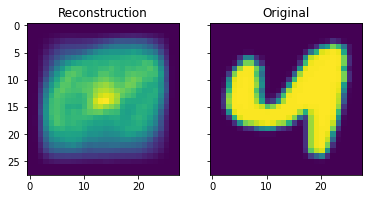

Reconstruction loss 277.56378173828125, Kullback Leibler divergence 1.3857765197753906
Reconstruction loss 273.01300048828125, Kullback Leibler divergence 1.1736482381820679
Reconstruction loss 276.9635925292969, Kullback Leibler divergence 1.0767978429794312
Reconstruction loss 280.7375793457031, Kullback Leibler divergence 1.4054672718048096
Reconstruction loss 271.7688293457031, Kullback Leibler divergence 1.3480405807495117
Reconstruction loss 273.7078552246094, Kullback Leibler divergence 1.6359076499938965
Reconstruction loss 272.7522888183594, Kullback Leibler divergence 1.891290545463562
Reconstruction loss 268.3847351074219, Kullback Leibler divergence 2.168008327484131
Reconstruction loss 269.8761291503906, Kullback Leibler divergence 1.9210509061813354
Reconstruction loss 269.95281982421875, Kullback Leibler divergence 1.8797082901000977


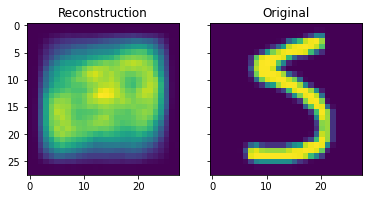

Reconstruction loss 269.13800048828125, Kullback Leibler divergence 1.7226436138153076
Reconstruction loss 273.1460266113281, Kullback Leibler divergence 1.600394606590271
Reconstruction loss 267.12615966796875, Kullback Leibler divergence 2.2074387073516846
Reconstruction loss 276.2085876464844, Kullback Leibler divergence 1.6242026090621948
Reconstruction loss 264.870849609375, Kullback Leibler divergence 1.669205665588379
Reconstruction loss 271.104736328125, Kullback Leibler divergence 1.6721972227096558
Reconstruction loss 270.8290710449219, Kullback Leibler divergence 1.6995501518249512
Reconstruction loss 272.00897216796875, Kullback Leibler divergence 1.6542772054672241
Reconstruction loss 282.62579345703125, Kullback Leibler divergence 1.9141793251037598
Reconstruction loss 265.308837890625, Kullback Leibler divergence 1.7681347131729126


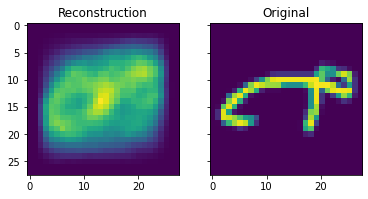

Reconstruction loss 272.1426086425781, Kullback Leibler divergence 1.6620641946792603
Reconstruction loss 274.8997497558594, Kullback Leibler divergence 1.4041937589645386
Reconstruction loss 268.9752197265625, Kullback Leibler divergence 1.6477688550949097
Reconstruction loss 279.17913818359375, Kullback Leibler divergence 1.3275049924850464
Reconstruction loss 283.22674560546875, Kullback Leibler divergence 1.392548680305481
Reconstruction loss 277.3218078613281, Kullback Leibler divergence 1.220678448677063
Reconstruction loss 271.4382629394531, Kullback Leibler divergence 1.8834301233291626
Reconstruction loss 270.9498291015625, Kullback Leibler divergence 1.532199740409851
Reconstruction loss 275.0817565917969, Kullback Leibler divergence 1.8427320718765259
Reconstruction loss 270.8922119140625, Kullback Leibler divergence 1.5246342420578003


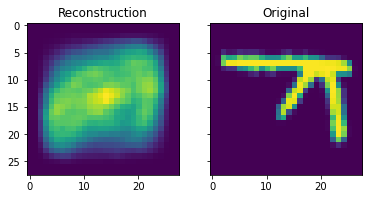

Reconstruction loss 275.4829406738281, Kullback Leibler divergence 1.556660771369934
Reconstruction loss 278.171630859375, Kullback Leibler divergence 1.6543362140655518
Reconstruction loss 266.108154296875, Kullback Leibler divergence 1.850549578666687
Reconstruction loss 272.1767883300781, Kullback Leibler divergence 1.946982741355896
Reconstruction loss 269.755615234375, Kullback Leibler divergence 2.026181697845459
Reconstruction loss 276.0841979980469, Kullback Leibler divergence 2.059657335281372
Reconstruction loss 268.7077941894531, Kullback Leibler divergence 1.9357682466506958
Reconstruction loss 272.21905517578125, Kullback Leibler divergence 2.095245361328125
Reconstruction loss 274.4599914550781, Kullback Leibler divergence 2.7176451683044434
Reconstruction loss 272.0236511230469, Kullback Leibler divergence 2.099311590194702


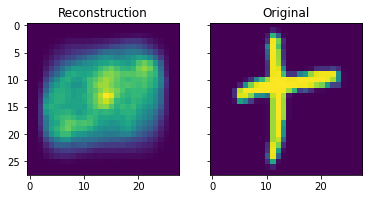

Reconstruction loss 270.2716064453125, Kullback Leibler divergence 2.734252691268921
Reconstruction loss 269.6772155761719, Kullback Leibler divergence 2.3338990211486816
Reconstruction loss 273.6600646972656, Kullback Leibler divergence 1.644993782043457
Reconstruction loss 266.698486328125, Kullback Leibler divergence 1.8724644184112549
Reconstruction loss 263.4825439453125, Kullback Leibler divergence 2.0381860733032227
Reconstruction loss 272.8737487792969, Kullback Leibler divergence 2.2150886058807373
Reconstruction loss 271.7610168457031, Kullback Leibler divergence 2.245771884918213
Reconstruction loss 263.6173095703125, Kullback Leibler divergence 2.4660086631774902
Reconstruction loss 259.7039489746094, Kullback Leibler divergence 2.3975768089294434
Reconstruction loss 270.2264709472656, Kullback Leibler divergence 3.6872315406799316


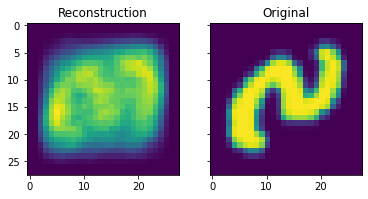

Reconstruction loss 259.36358642578125, Kullback Leibler divergence 2.789361000061035
Reconstruction loss 258.990234375, Kullback Leibler divergence 2.701874017715454
Reconstruction loss 261.0482482910156, Kullback Leibler divergence 3.863417387008667
Reconstruction loss 261.02398681640625, Kullback Leibler divergence 3.6941275596618652
Reconstruction loss 256.009033203125, Kullback Leibler divergence 2.954824209213257
Reconstruction loss 267.30242919921875, Kullback Leibler divergence 2.959521532058716
Reconstruction loss 268.8586730957031, Kullback Leibler divergence 3.285200595855713
Reconstruction loss 262.935302734375, Kullback Leibler divergence 2.6911661624908447
Reconstruction loss 264.4468994140625, Kullback Leibler divergence 2.517821788787842
Reconstruction loss 265.9149169921875, Kullback Leibler divergence 2.134284734725952


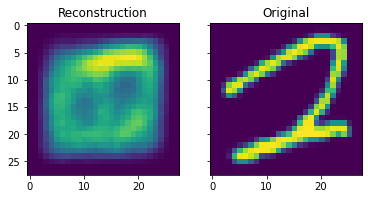

Reconstruction loss 260.7238464355469, Kullback Leibler divergence 2.6611874103546143
Reconstruction loss 261.6856384277344, Kullback Leibler divergence 3.3983521461486816
Reconstruction loss 262.1449890136719, Kullback Leibler divergence 3.0517988204956055
Reconstruction loss 263.13824462890625, Kullback Leibler divergence 2.9637198448181152
Reconstruction loss 267.0493469238281, Kullback Leibler divergence 2.5640804767608643
Reconstruction loss 269.171875, Kullback Leibler divergence 2.82470703125
Reconstruction loss 263.754150390625, Kullback Leibler divergence 3.3892252445220947
Reconstruction loss 266.77398681640625, Kullback Leibler divergence 3.4523677825927734
Reconstruction loss 254.88055419921875, Kullback Leibler divergence 3.7175650596618652
Reconstruction loss 258.816650390625, Kullback Leibler divergence 3.18845796585083


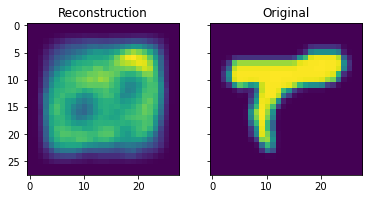

Reconstruction loss 257.6277770996094, Kullback Leibler divergence 3.839487314224243
Reconstruction loss 264.2181396484375, Kullback Leibler divergence 2.8769965171813965
Reconstruction loss 268.59539794921875, Kullback Leibler divergence 2.9457077980041504
Reconstruction loss 256.54827880859375, Kullback Leibler divergence 2.9126780033111572
Reconstruction loss 264.2207336425781, Kullback Leibler divergence 2.8136305809020996
Reconstruction loss 271.8594970703125, Kullback Leibler divergence 3.200974941253662
Reconstruction loss 262.86944580078125, Kullback Leibler divergence 2.617981195449829
Reconstruction loss 265.0849304199219, Kullback Leibler divergence 3.2888803482055664
Reconstruction loss 264.63226318359375, Kullback Leibler divergence 3.2620160579681396
Reconstruction loss 260.9696044921875, Kullback Leibler divergence 3.41630220413208


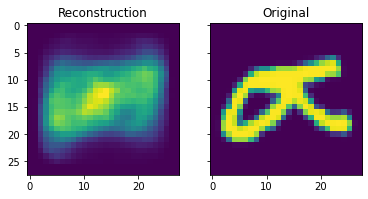

Reconstruction loss 261.5390319824219, Kullback Leibler divergence 3.1894781589508057
Reconstruction loss 258.14202880859375, Kullback Leibler divergence 3.855825901031494
Reconstruction loss 262.3798522949219, Kullback Leibler divergence 3.2476682662963867
Reconstruction loss 255.30567932128906, Kullback Leibler divergence 3.2139859199523926
Reconstruction loss 258.82244873046875, Kullback Leibler divergence 3.439049482345581
Reconstruction loss 255.2059783935547, Kullback Leibler divergence 3.3227241039276123
Reconstruction loss 251.2564239501953, Kullback Leibler divergence 2.9254910945892334
Reconstruction loss 259.992919921875, Kullback Leibler divergence 3.057033061981201
Reconstruction loss 262.36285400390625, Kullback Leibler divergence 3.4033925533294678
Reconstruction loss 257.90643310546875, Kullback Leibler divergence 3.4943835735321045


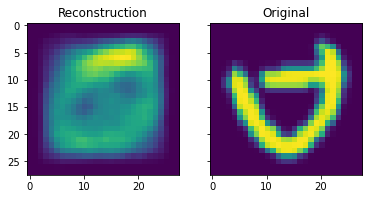

Reconstruction loss 261.5443420410156, Kullback Leibler divergence 3.8240747451782227
Reconstruction loss 244.77418518066406, Kullback Leibler divergence 4.129075527191162
Reconstruction loss 262.261474609375, Kullback Leibler divergence 2.983132839202881
Reconstruction loss 256.8159484863281, Kullback Leibler divergence 3.0505030155181885
Reconstruction loss 258.0617980957031, Kullback Leibler divergence 3.0395009517669678
Reconstruction loss 260.0672912597656, Kullback Leibler divergence 2.6227965354919434
Reconstruction loss 266.2056884765625, Kullback Leibler divergence 2.8048956394195557
Reconstruction loss 261.69793701171875, Kullback Leibler divergence 2.9700262546539307
Reconstruction loss 255.44020080566406, Kullback Leibler divergence 3.7496142387390137
Reconstruction loss 261.5495910644531, Kullback Leibler divergence 3.7133960723876953


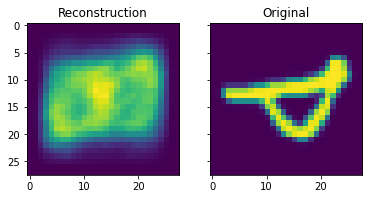

Reconstruction loss 259.2182922363281, Kullback Leibler divergence 3.682023525238037
Reconstruction loss 256.8684997558594, Kullback Leibler divergence 3.761337995529175
Reconstruction loss 259.4768371582031, Kullback Leibler divergence 3.252277135848999
Reconstruction loss 265.1713562011719, Kullback Leibler divergence 3.4041025638580322
Reconstruction loss 251.5903778076172, Kullback Leibler divergence 3.4833409786224365
Reconstruction loss 253.20785522460938, Kullback Leibler divergence 4.049559116363525
Reconstruction loss 263.2118225097656, Kullback Leibler divergence 3.9045464992523193
Reconstruction loss 262.75, Kullback Leibler divergence 3.733131170272827
Reconstruction loss 250.44149780273438, Kullback Leibler divergence 4.2312092781066895
Reconstruction loss 248.91810607910156, Kullback Leibler divergence 3.8767387866973877


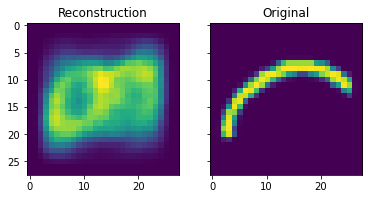

Reconstruction loss 259.4397277832031, Kullback Leibler divergence 3.731062889099121
Reconstruction loss 262.1268615722656, Kullback Leibler divergence 2.878098249435425
Reconstruction loss 266.1094970703125, Kullback Leibler divergence 3.184413194656372
Reconstruction loss 258.1160583496094, Kullback Leibler divergence 3.4182348251342773
Reconstruction loss 269.037353515625, Kullback Leibler divergence 3.895968437194824
Reconstruction loss 250.01824951171875, Kullback Leibler divergence 4.149909019470215
Reconstruction loss 254.2816162109375, Kullback Leibler divergence 4.000009059906006
Reconstruction loss 270.0068664550781, Kullback Leibler divergence 3.9225831031799316
Reconstruction loss 254.92959594726562, Kullback Leibler divergence 4.298213005065918
Reconstruction loss 261.3940734863281, Kullback Leibler divergence 4.031691074371338


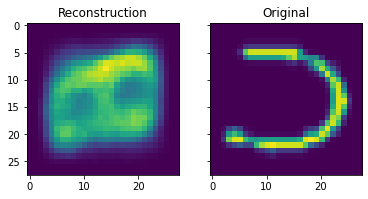

Reconstruction loss 255.95867919921875, Kullback Leibler divergence 4.7234392166137695
Reconstruction loss 264.4753723144531, Kullback Leibler divergence 3.985405206680298
Reconstruction loss 250.7097625732422, Kullback Leibler divergence 4.37855339050293
Reconstruction loss 258.0806579589844, Kullback Leibler divergence 4.305943489074707
Reconstruction loss 251.7382049560547, Kullback Leibler divergence 4.390406608581543
Reconstruction loss 254.07058715820312, Kullback Leibler divergence 4.145566463470459
Reconstruction loss 254.0072021484375, Kullback Leibler divergence 3.9309728145599365
Reconstruction loss 255.9892120361328, Kullback Leibler divergence 4.051828861236572
Reconstruction loss 248.1832275390625, Kullback Leibler divergence 3.789900541305542
Reconstruction loss 242.6101531982422, Kullback Leibler divergence 3.9408609867095947


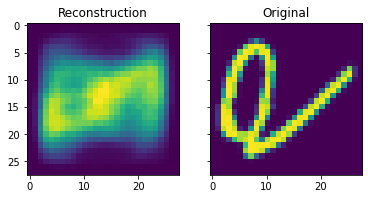

Reconstruction loss 256.7967834472656, Kullback Leibler divergence 3.934720993041992
Reconstruction loss 247.38697814941406, Kullback Leibler divergence 3.9776251316070557
Reconstruction loss 254.83160400390625, Kullback Leibler divergence 4.134624004364014
Reconstruction loss 246.04026794433594, Kullback Leibler divergence 4.349099636077881
Reconstruction loss 262.2526550292969, Kullback Leibler divergence 4.442898273468018
Reconstruction loss 252.0256805419922, Kullback Leibler divergence 3.982694625854492
Reconstruction loss 248.06558227539062, Kullback Leibler divergence 4.096487522125244
Reconstruction loss 246.3488311767578, Kullback Leibler divergence 4.441221714019775
Reconstruction loss 264.4333190917969, Kullback Leibler divergence 4.473815441131592
Reconstruction loss 256.1493225097656, Kullback Leibler divergence 4.406936168670654


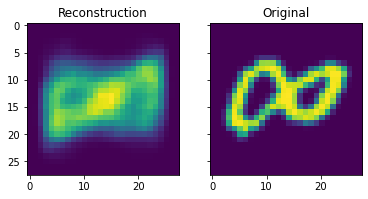

Reconstruction loss 256.0838928222656, Kullback Leibler divergence 5.035464286804199
Reconstruction loss 251.3048095703125, Kullback Leibler divergence 4.488650321960449
Reconstruction loss 247.87179565429688, Kullback Leibler divergence 4.337186813354492
Reconstruction loss 255.70082092285156, Kullback Leibler divergence 4.063008785247803
Reconstruction loss 260.0718078613281, Kullback Leibler divergence 3.832592248916626
Reconstruction loss 249.71710205078125, Kullback Leibler divergence 4.151170253753662
Reconstruction loss 254.46490478515625, Kullback Leibler divergence 4.379176616668701
Reconstruction loss 252.66796875, Kullback Leibler divergence 4.35828161239624
Reconstruction loss 239.62753295898438, Kullback Leibler divergence 5.60310173034668
Reconstruction loss 247.4077606201172, Kullback Leibler divergence 5.030442237854004


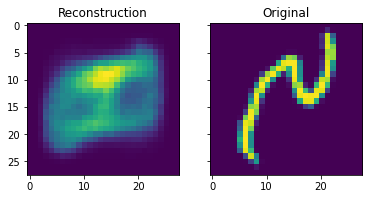

Reconstruction loss 254.19309997558594, Kullback Leibler divergence 4.914247512817383
Reconstruction loss 243.63914489746094, Kullback Leibler divergence 4.629701614379883
Reconstruction loss 250.57748413085938, Kullback Leibler divergence 4.831914901733398
Reconstruction loss 256.1556701660156, Kullback Leibler divergence 4.782296657562256
Reconstruction loss 245.67124938964844, Kullback Leibler divergence 4.990070343017578
Reconstruction loss 256.3052673339844, Kullback Leibler divergence 4.969644546508789
Reconstruction loss 248.88058471679688, Kullback Leibler divergence 4.814486503601074
Reconstruction loss 241.4301300048828, Kullback Leibler divergence 4.672300338745117
Reconstruction loss 246.38441467285156, Kullback Leibler divergence 5.40200138092041
Reconstruction loss 248.56265258789062, Kullback Leibler divergence 4.454529285430908


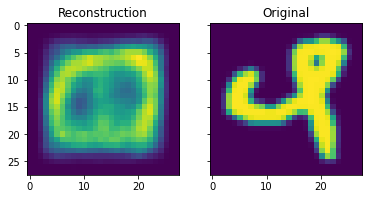

Reconstruction loss 241.59230041503906, Kullback Leibler divergence 4.446417808532715
Reconstruction loss 241.5596923828125, Kullback Leibler divergence 4.7518391609191895
Reconstruction loss 243.73362731933594, Kullback Leibler divergence 4.844606399536133
Reconstruction loss 242.02809143066406, Kullback Leibler divergence 4.845111846923828
Reconstruction loss 252.9911346435547, Kullback Leibler divergence 4.132427215576172
Reconstruction loss 242.5341033935547, Kullback Leibler divergence 4.299138069152832
Reconstruction loss 236.31625366210938, Kullback Leibler divergence 4.497546672821045
Reconstruction loss 242.06903076171875, Kullback Leibler divergence 4.665834426879883
Reconstruction loss 243.61251831054688, Kullback Leibler divergence 4.9328999519348145
Reconstruction loss 245.94296264648438, Kullback Leibler divergence 4.901262283325195


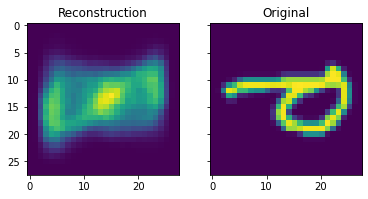

Reconstruction loss 244.8214111328125, Kullback Leibler divergence 5.139448165893555
Reconstruction loss 250.9236297607422, Kullback Leibler divergence 4.69537353515625
Reconstruction loss 248.4733428955078, Kullback Leibler divergence 4.949625015258789
Reconstruction loss 241.9503936767578, Kullback Leibler divergence 5.020428657531738
Reconstruction loss 246.86044311523438, Kullback Leibler divergence 4.920159816741943
Reconstruction loss 249.24386596679688, Kullback Leibler divergence 5.2021894454956055
Reconstruction loss 239.97230529785156, Kullback Leibler divergence 5.4791789054870605
Reconstruction loss 233.00926208496094, Kullback Leibler divergence 5.1968159675598145
Reconstruction loss 242.50628662109375, Kullback Leibler divergence 5.365634918212891
Reconstruction loss 242.53953552246094, Kullback Leibler divergence 5.452091693878174


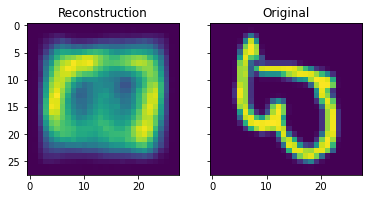

Reconstruction loss 252.18235778808594, Kullback Leibler divergence 5.184567928314209
Reconstruction loss 237.99366760253906, Kullback Leibler divergence 5.052656650543213
Reconstruction loss 239.5244598388672, Kullback Leibler divergence 5.3298139572143555
Reconstruction loss 244.1076202392578, Kullback Leibler divergence 5.213658332824707
Reconstruction loss 239.32464599609375, Kullback Leibler divergence 5.082598686218262
Reconstruction loss 241.93617248535156, Kullback Leibler divergence 4.965298652648926
Reconstruction loss 237.6307373046875, Kullback Leibler divergence 5.529909133911133
Reconstruction loss 234.11602783203125, Kullback Leibler divergence 5.5203962326049805
Reconstruction loss 236.97296142578125, Kullback Leibler divergence 5.138278961181641
Reconstruction loss 244.53384399414062, Kullback Leibler divergence 5.749457836151123


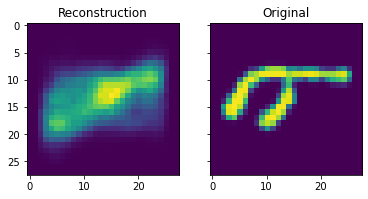

Reconstruction loss 245.7827606201172, Kullback Leibler divergence 5.724566459655762
Reconstruction loss 235.1796875, Kullback Leibler divergence 5.699343681335449
Reconstruction loss 240.8966827392578, Kullback Leibler divergence 5.739352226257324
Reconstruction loss 242.03179931640625, Kullback Leibler divergence 5.543659210205078
Reconstruction loss 241.14308166503906, Kullback Leibler divergence 5.94784688949585
Reconstruction loss 239.1913299560547, Kullback Leibler divergence 5.915731430053711
Reconstruction loss 241.46426391601562, Kullback Leibler divergence 5.794405460357666
Reconstruction loss 240.94866943359375, Kullback Leibler divergence 5.824230194091797
Reconstruction loss 239.8800048828125, Kullback Leibler divergence 5.62110710144043
Reconstruction loss 238.3325653076172, Kullback Leibler divergence 5.60137939453125


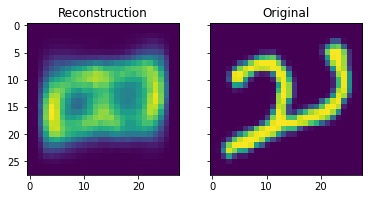

Reconstruction loss 233.36737060546875, Kullback Leibler divergence 5.9952778816223145
Reconstruction loss 243.99484252929688, Kullback Leibler divergence 5.7866387367248535
Reconstruction loss 237.1325225830078, Kullback Leibler divergence 5.600136756896973
Reconstruction loss 229.34788513183594, Kullback Leibler divergence 6.326400279998779
Reconstruction loss 229.07958984375, Kullback Leibler divergence 5.912132740020752
Reconstruction loss 241.52658081054688, Kullback Leibler divergence 6.016926288604736
Reconstruction loss 249.05836486816406, Kullback Leibler divergence 6.297818660736084
Reconstruction loss 240.0166473388672, Kullback Leibler divergence 5.855340957641602
Reconstruction loss 233.40219116210938, Kullback Leibler divergence 6.172255039215088
Reconstruction loss 233.46888732910156, Kullback Leibler divergence 6.18532657623291


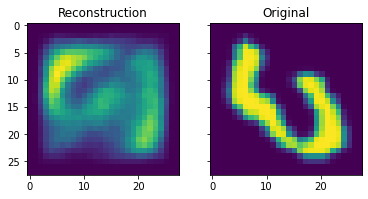

Reconstruction loss 240.6582794189453, Kullback Leibler divergence 5.999119758605957
Reconstruction loss 235.44410705566406, Kullback Leibler divergence 6.0214691162109375
Reconstruction loss 240.92691040039062, Kullback Leibler divergence 5.614145278930664
Reconstruction loss 235.48300170898438, Kullback Leibler divergence 6.1223225593566895
Reconstruction loss 229.77439880371094, Kullback Leibler divergence 5.9170966148376465
Reconstruction loss 233.7754364013672, Kullback Leibler divergence 6.2193098068237305
Reconstruction loss 230.12269592285156, Kullback Leibler divergence 6.412099838256836
Reconstruction loss 232.96841430664062, Kullback Leibler divergence 6.327617168426514
Reconstruction loss 229.5007781982422, Kullback Leibler divergence 6.874536037445068
Reconstruction loss 228.03829956054688, Kullback Leibler divergence 6.200687408447266


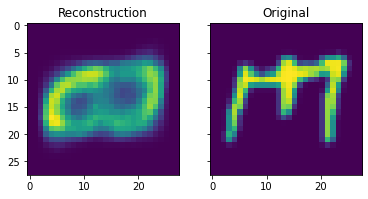

Reconstruction loss 236.12442016601562, Kullback Leibler divergence 6.417654991149902
Reconstruction loss 242.0283966064453, Kullback Leibler divergence 6.013377666473389
Reconstruction loss 237.26327514648438, Kullback Leibler divergence 6.777219295501709
Reconstruction loss 237.4170379638672, Kullback Leibler divergence 6.614267349243164
Reconstruction loss 237.5762176513672, Kullback Leibler divergence 6.635994911193848
Reconstruction loss 225.5664520263672, Kullback Leibler divergence 6.519003391265869
Reconstruction loss 220.3580322265625, Kullback Leibler divergence 6.5534749031066895
Reconstruction loss 241.38890075683594, Kullback Leibler divergence 6.9564056396484375
Reconstruction loss 232.3536376953125, Kullback Leibler divergence 7.089682102203369
Reconstruction loss 236.70352172851562, Kullback Leibler divergence 7.0802083015441895


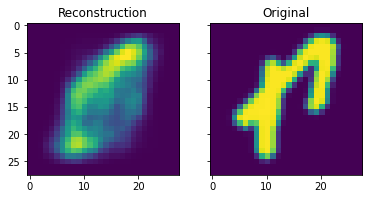

Reconstruction loss 228.69773864746094, Kullback Leibler divergence 7.2610673904418945
Reconstruction loss 235.42300415039062, Kullback Leibler divergence 7.179487228393555
Reconstruction loss 227.77503967285156, Kullback Leibler divergence 7.233752250671387
Reconstruction loss 232.8360595703125, Kullback Leibler divergence 7.239687442779541
Reconstruction loss 233.3362274169922, Kullback Leibler divergence 7.265860080718994
Reconstruction loss 224.6416473388672, Kullback Leibler divergence 8.096766471862793
Reconstruction loss 229.07000732421875, Kullback Leibler divergence 8.164209365844727
Reconstruction loss 219.6750030517578, Kullback Leibler divergence 7.527143955230713
Reconstruction loss 228.9396514892578, Kullback Leibler divergence 7.147684097290039
Reconstruction loss 231.32054138183594, Kullback Leibler divergence 6.655541896820068


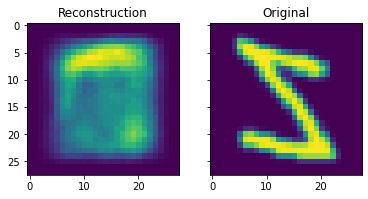

Reconstruction loss 230.2773895263672, Kullback Leibler divergence 6.682211875915527
Reconstruction loss 227.46881103515625, Kullback Leibler divergence 7.295318603515625
Reconstruction loss 231.2645721435547, Kullback Leibler divergence 7.108967304229736
Reconstruction loss 225.3085479736328, Kullback Leibler divergence 7.425243377685547
Reconstruction loss 225.31976318359375, Kullback Leibler divergence 7.988541126251221
Reconstruction loss 232.53111267089844, Kullback Leibler divergence 7.498154163360596
Reconstruction loss 235.3546905517578, Kullback Leibler divergence 8.24655532836914
Reconstruction loss 228.9268035888672, Kullback Leibler divergence 8.027339935302734
Reconstruction loss 228.38388061523438, Kullback Leibler divergence 8.149359703063965
Reconstruction loss 223.1648406982422, Kullback Leibler divergence 8.26424789428711


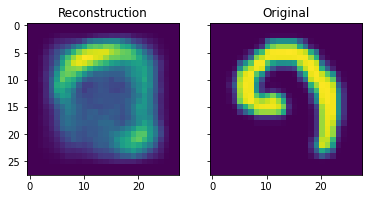

Reconstruction loss 236.43988037109375, Kullback Leibler divergence 7.30275821685791
Reconstruction loss 229.86029052734375, Kullback Leibler divergence 7.355161190032959
Reconstruction loss 220.02545166015625, Kullback Leibler divergence 7.656174182891846
Reconstruction loss 233.60206604003906, Kullback Leibler divergence 7.2425737380981445
Reconstruction loss 226.51425170898438, Kullback Leibler divergence 7.124447822570801
Reconstruction loss 226.24072265625, Kullback Leibler divergence 6.946232795715332
Reconstruction loss 227.90847778320312, Kullback Leibler divergence 7.004220485687256
Reconstruction loss 226.11782836914062, Kullback Leibler divergence 7.385027885437012
Reconstruction loss 231.55191040039062, Kullback Leibler divergence 7.399237632751465
Reconstruction loss 221.70758056640625, Kullback Leibler divergence 8.279227256774902


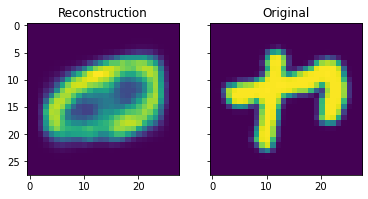

Reconstruction loss 224.66366577148438, Kullback Leibler divergence 8.416169166564941
Reconstruction loss 220.01463317871094, Kullback Leibler divergence 8.234926223754883
Reconstruction loss 223.2988739013672, Kullback Leibler divergence 8.120532035827637
Reconstruction loss 227.34878540039062, Kullback Leibler divergence 8.214314460754395
Reconstruction loss 227.89056396484375, Kullback Leibler divergence 8.132396697998047
Reconstruction loss 222.29031372070312, Kullback Leibler divergence 8.241215705871582
Reconstruction loss 240.8630828857422, Kullback Leibler divergence 8.274025917053223
Reconstruction loss 233.74832153320312, Kullback Leibler divergence 8.109020233154297
Reconstruction loss 215.2325439453125, Kullback Leibler divergence 7.600347995758057
Reconstruction loss 237.09361267089844, Kullback Leibler divergence 7.439808368682861


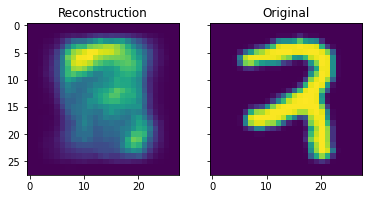

Reconstruction loss 226.1855010986328, Kullback Leibler divergence 7.3478546142578125
Reconstruction loss 217.10287475585938, Kullback Leibler divergence 7.890740871429443
Reconstruction loss 227.1035919189453, Kullback Leibler divergence 7.805293083190918
Reconstruction loss 221.3715362548828, Kullback Leibler divergence 8.86890697479248
Reconstruction loss 219.3310546875, Kullback Leibler divergence 8.596940040588379
Reconstruction loss 222.93824768066406, Kullback Leibler divergence 8.561430931091309
Reconstruction loss 225.06202697753906, Kullback Leibler divergence 8.826393127441406
Reconstruction loss 216.5526580810547, Kullback Leibler divergence 8.399785995483398
Reconstruction loss 217.58961486816406, Kullback Leibler divergence 8.549395561218262
Reconstruction loss 224.87042236328125, Kullback Leibler divergence 8.8666410446167


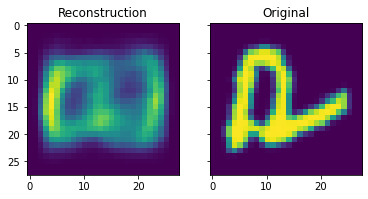

Reconstruction loss 222.14382934570312, Kullback Leibler divergence 9.573221206665039
Reconstruction loss 226.3809356689453, Kullback Leibler divergence 9.359138488769531
Reconstruction loss 227.47784423828125, Kullback Leibler divergence 9.338837623596191
Reconstruction loss 219.8535614013672, Kullback Leibler divergence 9.334185600280762
Reconstruction loss 210.83676147460938, Kullback Leibler divergence 9.407681465148926
Reconstruction loss 222.41436767578125, Kullback Leibler divergence 9.282093048095703
Reconstruction loss 211.46945190429688, Kullback Leibler divergence 9.234891891479492
Reconstruction loss 221.11407470703125, Kullback Leibler divergence 9.127638816833496
Reconstruction loss 220.15406799316406, Kullback Leibler divergence 9.351363182067871
Reconstruction loss 225.83740234375, Kullback Leibler divergence 9.872507095336914


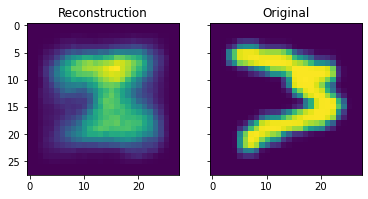

Reconstruction loss 226.1330108642578, Kullback Leibler divergence 9.615537643432617
Reconstruction loss 217.64718627929688, Kullback Leibler divergence 10.125228881835938
Reconstruction loss 215.25511169433594, Kullback Leibler divergence 10.092514991760254
Reconstruction loss 214.26644897460938, Kullback Leibler divergence 10.147549629211426
Reconstruction loss 212.91871643066406, Kullback Leibler divergence 10.579659461975098
Reconstruction loss 227.3475341796875, Kullback Leibler divergence 10.187169075012207
Reconstruction loss 211.46722412109375, Kullback Leibler divergence 10.230945587158203
Reconstruction loss 210.2735137939453, Kullback Leibler divergence 10.676409721374512
Reconstruction loss 207.4084014892578, Kullback Leibler divergence 10.781604766845703
Reconstruction loss 214.6676788330078, Kullback Leibler divergence 10.475976943969727


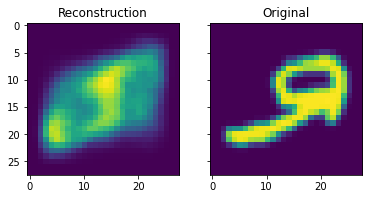

Reconstruction loss 224.462890625, Kullback Leibler divergence 10.19857406616211
Reconstruction loss 209.93292236328125, Kullback Leibler divergence 9.962838172912598
Reconstruction loss 211.0611572265625, Kullback Leibler divergence 9.797698020935059
Reconstruction loss 209.88516235351562, Kullback Leibler divergence 10.335670471191406
Reconstruction loss 213.8294677734375, Kullback Leibler divergence 10.055157661437988
Reconstruction loss 210.1944580078125, Kullback Leibler divergence 10.429184913635254
Reconstruction loss 205.54513549804688, Kullback Leibler divergence 10.968274116516113
Reconstruction loss 211.10025024414062, Kullback Leibler divergence 11.285017967224121
Reconstruction loss 205.93089294433594, Kullback Leibler divergence 11.391578674316406
Reconstruction loss 213.5078887939453, Kullback Leibler divergence 11.830552101135254


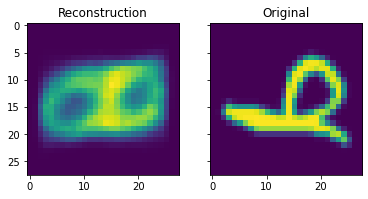

Reconstruction loss 211.71115112304688, Kullback Leibler divergence 11.790101051330566
Reconstruction loss 210.10304260253906, Kullback Leibler divergence 10.723416328430176
Reconstruction loss 211.95291137695312, Kullback Leibler divergence 11.232693672180176
Reconstruction loss 212.16676330566406, Kullback Leibler divergence 11.602447509765625
Reconstruction loss 210.68211364746094, Kullback Leibler divergence 11.45313835144043
Reconstruction loss 203.5211944580078, Kullback Leibler divergence 10.41186809539795
Reconstruction loss 206.6132354736328, Kullback Leibler divergence 10.442724227905273
Reconstruction loss 202.19021606445312, Kullback Leibler divergence 10.148839950561523
Reconstruction loss 206.45668029785156, Kullback Leibler divergence 10.663763046264648
Reconstruction loss 213.96697998046875, Kullback Leibler divergence 11.165811538696289


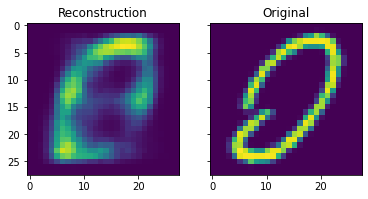

Reconstruction loss 207.4208221435547, Kullback Leibler divergence 11.75091552734375
Reconstruction loss 205.19114685058594, Kullback Leibler divergence 11.852374076843262
Reconstruction loss 207.9834747314453, Kullback Leibler divergence 11.518338203430176
Reconstruction loss 203.61676025390625, Kullback Leibler divergence 12.027386665344238
Reconstruction loss 197.9236297607422, Kullback Leibler divergence 11.84094524383545
Reconstruction loss 207.0552978515625, Kullback Leibler divergence 11.479287147521973
Reconstruction loss 204.33819580078125, Kullback Leibler divergence 10.991458892822266
Reconstruction loss 199.7724151611328, Kullback Leibler divergence 11.146967887878418
Reconstruction loss 212.57728576660156, Kullback Leibler divergence 11.12946891784668
Reconstruction loss 208.37570190429688, Kullback Leibler divergence 11.795672416687012


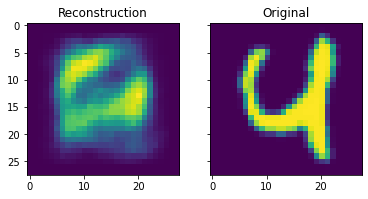

Reconstruction loss 200.7755889892578, Kullback Leibler divergence 12.251306533813477
Reconstruction loss 204.0782470703125, Kullback Leibler divergence 11.883495330810547
Reconstruction loss 195.14678955078125, Kullback Leibler divergence 11.941372871398926
Reconstruction loss 211.45411682128906, Kullback Leibler divergence 12.445700645446777
Reconstruction loss 210.00355529785156, Kullback Leibler divergence 12.126447677612305
Reconstruction loss 200.17730712890625, Kullback Leibler divergence 12.314126968383789
Reconstruction loss 204.35733032226562, Kullback Leibler divergence 12.364174842834473
Reconstruction loss 210.80531311035156, Kullback Leibler divergence 11.91296100616455
Reconstruction loss 193.50360107421875, Kullback Leibler divergence 12.304160118103027
Reconstruction loss 198.95736694335938, Kullback Leibler divergence 12.159124374389648


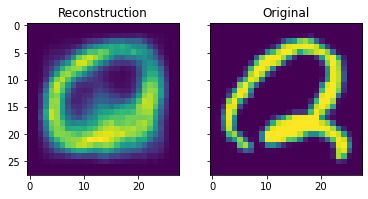

Reconstruction loss 202.99607849121094, Kullback Leibler divergence 11.96352767944336
Reconstruction loss 202.2313232421875, Kullback Leibler divergence 12.313878059387207
Reconstruction loss 199.61215209960938, Kullback Leibler divergence 12.673184394836426
Reconstruction loss 195.9061279296875, Kullback Leibler divergence 12.830979347229004
Reconstruction loss 200.15667724609375, Kullback Leibler divergence 12.747507095336914
Reconstruction loss 206.24349975585938, Kullback Leibler divergence 12.176081657409668
Reconstruction loss 198.72093200683594, Kullback Leibler divergence 12.297884941101074
Reconstruction loss 205.5370330810547, Kullback Leibler divergence 12.07366943359375
Reconstruction loss 198.7987060546875, Kullback Leibler divergence 11.77435302734375
Reconstruction loss 200.66461181640625, Kullback Leibler divergence 12.438376426696777


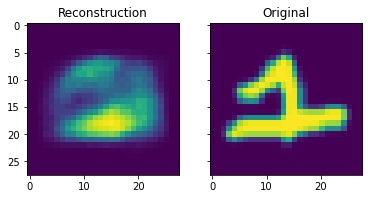

Reconstruction loss 200.90953063964844, Kullback Leibler divergence 12.7998628616333
Reconstruction loss 200.38987731933594, Kullback Leibler divergence 13.416614532470703
Reconstruction loss 195.79425048828125, Kullback Leibler divergence 13.377873420715332
Reconstruction loss 186.4157257080078, Kullback Leibler divergence 12.484920501708984
Reconstruction loss 193.51336669921875, Kullback Leibler divergence 12.794938087463379
Reconstruction loss 188.62213134765625, Kullback Leibler divergence 12.775877952575684
Reconstruction loss 202.8124542236328, Kullback Leibler divergence 12.988268852233887
Reconstruction loss 204.88002014160156, Kullback Leibler divergence 13.129486083984375
Reconstruction loss 206.04986572265625, Kullback Leibler divergence 12.926246643066406
Reconstruction loss 199.16139221191406, Kullback Leibler divergence 12.842084884643555


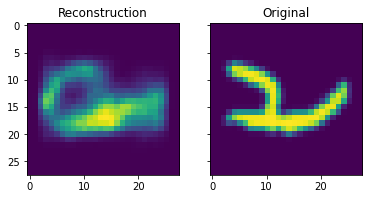

Reconstruction loss 196.2464599609375, Kullback Leibler divergence 12.750165939331055
Reconstruction loss 190.89273071289062, Kullback Leibler divergence 12.77365493774414
Reconstruction loss 199.9492950439453, Kullback Leibler divergence 12.54857063293457
Reconstruction loss 195.2987823486328, Kullback Leibler divergence 12.690242767333984
Reconstruction loss 194.28936767578125, Kullback Leibler divergence 13.170056343078613
Reconstruction loss 188.08535766601562, Kullback Leibler divergence 13.379420280456543
Reconstruction loss 197.09555053710938, Kullback Leibler divergence 12.973285675048828
Reconstruction loss 190.24737548828125, Kullback Leibler divergence 13.229724884033203
Reconstruction loss 187.6124267578125, Kullback Leibler divergence 13.912282943725586
Reconstruction loss 204.76577758789062, Kullback Leibler divergence 13.293069839477539


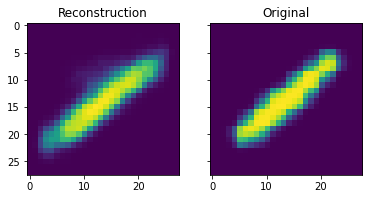

Reconstruction loss 195.89137268066406, Kullback Leibler divergence 13.412152290344238
Reconstruction loss 197.87945556640625, Kullback Leibler divergence 13.720603942871094
Reconstruction loss 192.47891235351562, Kullback Leibler divergence 13.108473777770996
Reconstruction loss 196.3985595703125, Kullback Leibler divergence 13.604033470153809
Reconstruction loss 195.99569702148438, Kullback Leibler divergence 13.450702667236328
Reconstruction loss 191.2587890625, Kullback Leibler divergence 13.211260795593262
Reconstruction loss 191.43016052246094, Kullback Leibler divergence 13.644547462463379
Reconstruction loss 185.31613159179688, Kullback Leibler divergence 13.943412780761719
Reconstruction loss 194.37625122070312, Kullback Leibler divergence 14.255402565002441
Reconstruction loss 187.4562530517578, Kullback Leibler divergence 14.052634239196777


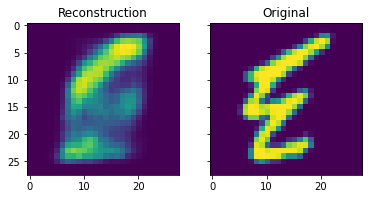

Reconstruction loss 181.63987731933594, Kullback Leibler divergence 14.367514610290527
Reconstruction loss 192.7850799560547, Kullback Leibler divergence 13.962113380432129
Reconstruction loss 190.4580535888672, Kullback Leibler divergence 14.338663101196289
Reconstruction loss 186.8292236328125, Kullback Leibler divergence 13.941794395446777
Reconstruction loss 197.4823760986328, Kullback Leibler divergence 13.7056245803833
Reconstruction loss 195.88108825683594, Kullback Leibler divergence 13.722634315490723
Reconstruction loss 187.0380096435547, Kullback Leibler divergence 13.768939971923828
Reconstruction loss 182.6444549560547, Kullback Leibler divergence 13.642928123474121
Reconstruction loss 190.22447204589844, Kullback Leibler divergence 14.296055793762207
Reconstruction loss 188.7050323486328, Kullback Leibler divergence 13.965941429138184


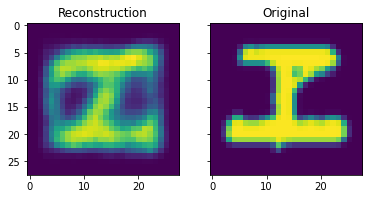

Reconstruction loss 182.3274383544922, Kullback Leibler divergence 13.920937538146973
Reconstruction loss 191.56069946289062, Kullback Leibler divergence 13.976912498474121
Reconstruction loss 191.0548858642578, Kullback Leibler divergence 14.447831153869629
Reconstruction loss 191.51409912109375, Kullback Leibler divergence 14.898975372314453
Reconstruction loss 187.77899169921875, Kullback Leibler divergence 14.907779693603516
Reconstruction loss 186.19554138183594, Kullback Leibler divergence 13.677228927612305
Reconstruction loss 189.7547607421875, Kullback Leibler divergence 13.501877784729004
Reconstruction loss 188.98184204101562, Kullback Leibler divergence 13.350290298461914
Reconstruction loss 182.06907653808594, Kullback Leibler divergence 13.462965965270996
Reconstruction loss 189.85276794433594, Kullback Leibler divergence 14.135527610778809


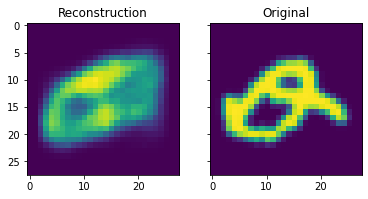

Reconstruction loss 184.12612915039062, Kullback Leibler divergence 14.931988716125488
Reconstruction loss 192.36427307128906, Kullback Leibler divergence 14.547115325927734
Reconstruction loss 188.86386108398438, Kullback Leibler divergence 14.296947479248047
Reconstruction loss 192.09652709960938, Kullback Leibler divergence 14.509725570678711
Reconstruction loss 190.15219116210938, Kullback Leibler divergence 13.904192924499512
Reconstruction loss 183.52056884765625, Kullback Leibler divergence 14.156002044677734
Reconstruction loss 190.17543029785156, Kullback Leibler divergence 13.816742897033691
Reconstruction loss 188.58758544921875, Kullback Leibler divergence 14.635876655578613
Reconstruction loss 186.5083770751953, Kullback Leibler divergence 14.782079696655273
Reconstruction loss 191.1758270263672, Kullback Leibler divergence 14.590707778930664


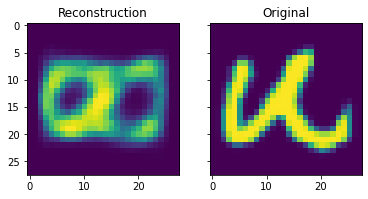

Reconstruction loss 188.51597595214844, Kullback Leibler divergence 15.148001670837402
Reconstruction loss 194.22679138183594, Kullback Leibler divergence 15.223099708557129
Reconstruction loss 181.7901611328125, Kullback Leibler divergence 15.308509826660156
Reconstruction loss 193.92022705078125, Kullback Leibler divergence 14.538288116455078
Reconstruction loss 184.22665405273438, Kullback Leibler divergence 14.580641746520996
Reconstruction loss 185.93148803710938, Kullback Leibler divergence 14.728742599487305
Reconstruction loss 180.75746154785156, Kullback Leibler divergence 14.34096908569336
Reconstruction loss 184.99533081054688, Kullback Leibler divergence 14.436169624328613
Reconstruction loss 186.6853485107422, Kullback Leibler divergence 14.231956481933594
Reconstruction loss 181.04779052734375, Kullback Leibler divergence 14.6826171875


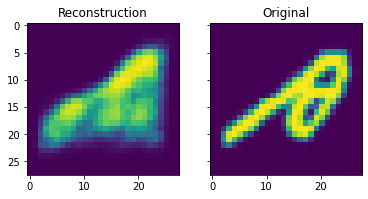

Reconstruction loss 184.65975952148438, Kullback Leibler divergence 14.678003311157227
Reconstruction loss 180.00437927246094, Kullback Leibler divergence 14.68577766418457
Reconstruction loss 178.86419677734375, Kullback Leibler divergence 14.744157791137695
Reconstruction loss 188.92820739746094, Kullback Leibler divergence 14.297601699829102
Reconstruction loss 189.8526153564453, Kullback Leibler divergence 14.415632247924805
Reconstruction loss 183.9092559814453, Kullback Leibler divergence 14.150971412658691
Reconstruction loss 181.9744110107422, Kullback Leibler divergence 14.943669319152832
Reconstruction loss 183.22972106933594, Kullback Leibler divergence 15.008293151855469
Reconstruction loss 178.2911376953125, Kullback Leibler divergence 15.019891738891602
Reconstruction loss 178.90390014648438, Kullback Leibler divergence 15.426718711853027


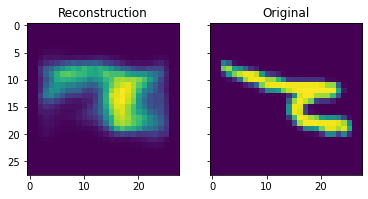

Reconstruction loss 177.53530883789062, Kullback Leibler divergence 16.081172943115234
Reconstruction loss 179.51507568359375, Kullback Leibler divergence 16.25697135925293
Reconstruction loss 178.5095672607422, Kullback Leibler divergence 15.883779525756836
Reconstruction loss 176.84596252441406, Kullback Leibler divergence 16.013080596923828
Reconstruction loss 177.09530639648438, Kullback Leibler divergence 15.301098823547363
Reconstruction loss 173.52163696289062, Kullback Leibler divergence 14.865351676940918
Reconstruction loss 180.02609252929688, Kullback Leibler divergence 14.102672576904297
Reconstruction loss 185.80593872070312, Kullback Leibler divergence 14.122703552246094
Reconstruction loss 184.98794555664062, Kullback Leibler divergence 14.804865837097168
Reconstruction loss 175.6869659423828, Kullback Leibler divergence 15.595229148864746


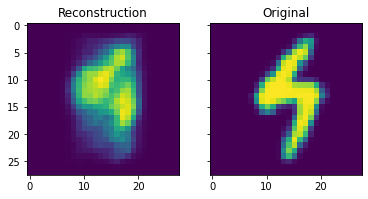

Reconstruction loss 175.03936767578125, Kullback Leibler divergence 15.99766731262207
Reconstruction loss 180.3623504638672, Kullback Leibler divergence 15.868001937866211
Reconstruction loss 191.57347106933594, Kullback Leibler divergence 15.518780708312988
Reconstruction loss 185.46388244628906, Kullback Leibler divergence 15.07893180847168
Reconstruction loss 177.97926330566406, Kullback Leibler divergence 15.199113845825195
Reconstruction loss 186.4864044189453, Kullback Leibler divergence 15.266657829284668
Reconstruction loss 183.5692901611328, Kullback Leibler divergence 14.967808723449707
Reconstruction loss 178.07113647460938, Kullback Leibler divergence 15.322762489318848
Reconstruction loss 187.94473266601562, Kullback Leibler divergence 15.573533058166504
Reconstruction loss 179.1075439453125, Kullback Leibler divergence 15.62118911743164


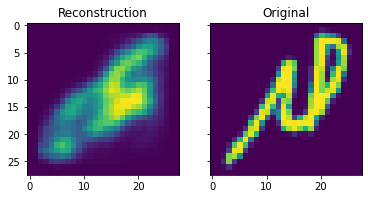

Reconstruction loss 178.25314331054688, Kullback Leibler divergence 15.230279922485352
Reconstruction loss 188.11155700683594, Kullback Leibler divergence 15.200865745544434
Reconstruction loss 180.2412567138672, Kullback Leibler divergence 15.767059326171875
Reconstruction loss 184.7384033203125, Kullback Leibler divergence 15.852347373962402
Reconstruction loss 173.74679565429688, Kullback Leibler divergence 16.16062355041504
Reconstruction loss 178.96754455566406, Kullback Leibler divergence 15.681832313537598
Reconstruction loss 187.14804077148438, Kullback Leibler divergence 15.098401069641113
Reconstruction loss 169.42376708984375, Kullback Leibler divergence 14.540074348449707
Reconstruction loss 175.98016357421875, Kullback Leibler divergence 15.247485160827637
Reconstruction loss 181.17120361328125, Kullback Leibler divergence 15.50343132019043


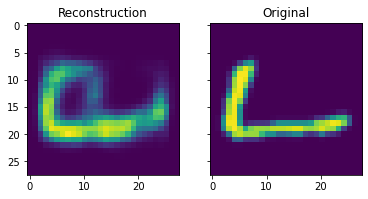

Reconstruction loss 180.51878356933594, Kullback Leibler divergence 16.29108238220215
Reconstruction loss 173.7033233642578, Kullback Leibler divergence 16.667417526245117
Reconstruction loss 176.2227325439453, Kullback Leibler divergence 16.28268051147461
Reconstruction loss 172.82504272460938, Kullback Leibler divergence 15.877333641052246
Reconstruction loss 182.9701690673828, Kullback Leibler divergence 14.783647537231445
Reconstruction loss 175.36639404296875, Kullback Leibler divergence 14.443744659423828
Reconstruction loss 185.67262268066406, Kullback Leibler divergence 14.822754859924316
Reconstruction loss 170.57015991210938, Kullback Leibler divergence 15.450674057006836
Reconstruction loss 164.11639404296875, Kullback Leibler divergence 16.035478591918945
Reconstruction loss 175.17724609375, Kullback Leibler divergence 15.893403053283691


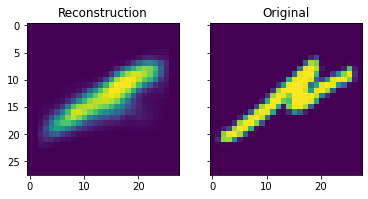

Reconstruction loss 170.04144287109375, Kullback Leibler divergence 15.996233940124512
Reconstruction loss 173.66175842285156, Kullback Leibler divergence 16.111330032348633
Reconstruction loss 181.76095581054688, Kullback Leibler divergence 16.461830139160156
Reconstruction loss 175.8706512451172, Kullback Leibler divergence 17.079204559326172
Reconstruction loss 173.15078735351562, Kullback Leibler divergence 16.78191566467285
Reconstruction loss 173.90786743164062, Kullback Leibler divergence 16.633869171142578
Reconstruction loss 170.14027404785156, Kullback Leibler divergence 15.682839393615723
Reconstruction loss 178.1845703125, Kullback Leibler divergence 14.839035987854004
Reconstruction loss 179.08090209960938, Kullback Leibler divergence 15.239635467529297
Reconstruction loss 180.7266387939453, Kullback Leibler divergence 15.514200210571289


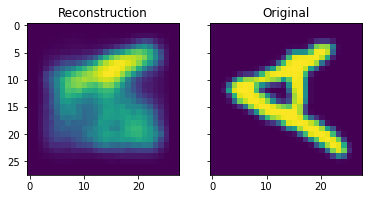

Reconstruction loss 170.2803497314453, Kullback Leibler divergence 16.069019317626953
Reconstruction loss 164.4208221435547, Kullback Leibler divergence 17.238996505737305
Reconstruction loss 175.5913848876953, Kullback Leibler divergence 17.197446823120117
Reconstruction loss 168.88800048828125, Kullback Leibler divergence 17.08618927001953
Reconstruction loss 177.7459716796875, Kullback Leibler divergence 16.368209838867188
Reconstruction loss 167.33749389648438, Kullback Leibler divergence 16.089313507080078
Reconstruction loss 179.60133361816406, Kullback Leibler divergence 15.613371849060059
Reconstruction loss 177.3794708251953, Kullback Leibler divergence 15.445600509643555
Reconstruction loss 166.8582763671875, Kullback Leibler divergence 15.297004699707031
Reconstruction loss 172.63038635253906, Kullback Leibler divergence 15.829671859741211


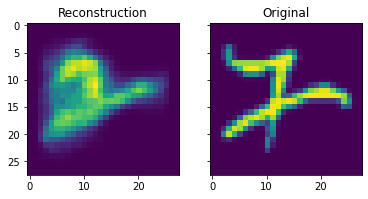

Reconstruction loss 172.51019287109375, Kullback Leibler divergence 16.342056274414062
Reconstruction loss 175.8591766357422, Kullback Leibler divergence 17.49897575378418
Reconstruction loss 179.96694946289062, Kullback Leibler divergence 17.580856323242188
Reconstruction loss 170.26954650878906, Kullback Leibler divergence 17.6636905670166
Reconstruction loss 169.73626708984375, Kullback Leibler divergence 17.21206283569336
Reconstruction loss 167.7856903076172, Kullback Leibler divergence 17.513330459594727
Reconstruction loss 172.47650146484375, Kullback Leibler divergence 16.1000919342041
Reconstruction loss 177.8896942138672, Kullback Leibler divergence 15.493454933166504
Reconstruction loss 178.08740234375, Kullback Leibler divergence 14.97231674194336
Reconstruction loss 172.88365173339844, Kullback Leibler divergence 15.176217079162598


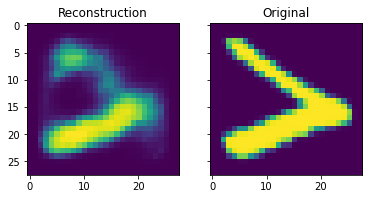

Reconstruction loss 180.67723083496094, Kullback Leibler divergence 15.898484230041504
Reconstruction loss 161.31744384765625, Kullback Leibler divergence 17.103195190429688
Reconstruction loss 172.74874877929688, Kullback Leibler divergence 17.2757568359375
Reconstruction loss 179.12330627441406, Kullback Leibler divergence 16.855113983154297
Reconstruction loss 175.72218322753906, Kullback Leibler divergence 16.524791717529297
Reconstruction loss 170.86669921875, Kullback Leibler divergence 16.26085662841797
Reconstruction loss 173.65965270996094, Kullback Leibler divergence 16.225257873535156
Reconstruction loss 170.13819885253906, Kullback Leibler divergence 16.36612319946289
Reconstruction loss 166.24874877929688, Kullback Leibler divergence 16.446569442749023
Reconstruction loss 174.12069702148438, Kullback Leibler divergence 16.117076873779297


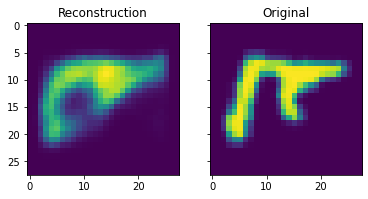

Reconstruction loss 170.72731018066406, Kullback Leibler divergence 16.35980796813965
Reconstruction loss 180.1273651123047, Kullback Leibler divergence 16.722986221313477
Reconstruction loss 172.15164184570312, Kullback Leibler divergence 16.69285011291504
Reconstruction loss 171.69874572753906, Kullback Leibler divergence 17.736955642700195
Reconstruction loss 179.96514892578125, Kullback Leibler divergence 17.388484954833984
Reconstruction loss 167.24334716796875, Kullback Leibler divergence 17.192440032958984
Reconstruction loss 179.2099609375, Kullback Leibler divergence 16.731687545776367
Reconstruction loss 174.94456481933594, Kullback Leibler divergence 16.146425247192383
Reconstruction loss 170.05526733398438, Kullback Leibler divergence 16.22564125061035
Reconstruction loss 169.5352325439453, Kullback Leibler divergence 16.17160987854004


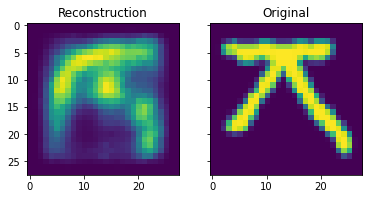

Reconstruction loss 171.83985900878906, Kullback Leibler divergence 16.6544246673584
Reconstruction loss 176.35601806640625, Kullback Leibler divergence 17.494422912597656
Reconstruction loss 170.05593872070312, Kullback Leibler divergence 17.866226196289062
Reconstruction loss 175.02308654785156, Kullback Leibler divergence 17.33616065979004
Reconstruction loss 178.26202392578125, Kullback Leibler divergence 16.82503890991211
Reconstruction loss 167.32542419433594, Kullback Leibler divergence 16.11394691467285
Reconstruction loss 174.1309356689453, Kullback Leibler divergence 15.6246919631958
Reconstruction loss 173.79457092285156, Kullback Leibler divergence 16.025978088378906
Reconstruction loss 177.82000732421875, Kullback Leibler divergence 16.290538787841797
Reconstruction loss 170.0406494140625, Kullback Leibler divergence 16.6586856842041


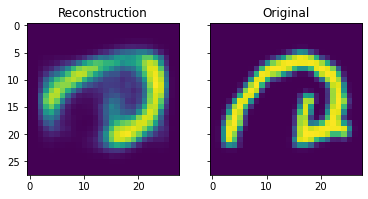

Reconstruction loss 175.9626922607422, Kullback Leibler divergence 17.17241859436035
Reconstruction loss 175.1121063232422, Kullback Leibler divergence 17.13368034362793
Reconstruction loss 170.7851104736328, Kullback Leibler divergence 16.60782814025879
Reconstruction loss 174.01609802246094, Kullback Leibler divergence 16.05280113220215
Reconstruction loss 173.12734985351562, Kullback Leibler divergence 15.906375885009766
Reconstruction loss 169.24838256835938, Kullback Leibler divergence 16.516735076904297
Reconstruction loss 170.42050170898438, Kullback Leibler divergence 16.711088180541992
Reconstruction loss 177.11155700683594, Kullback Leibler divergence 16.75859260559082
Reconstruction loss 172.3203125, Kullback Leibler divergence 17.060152053833008
Reconstruction loss 172.6650390625, Kullback Leibler divergence 16.893083572387695


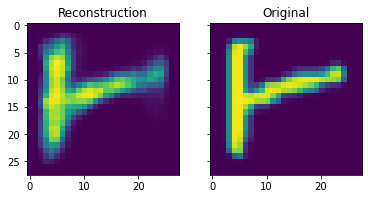

Reconstruction loss 167.20848083496094, Kullback Leibler divergence 16.351402282714844
Reconstruction loss 167.40757751464844, Kullback Leibler divergence 16.409317016601562
Reconstruction loss 163.7228546142578, Kullback Leibler divergence 16.480499267578125
Reconstruction loss 165.6192626953125, Kullback Leibler divergence 16.344755172729492
Reconstruction loss 164.02044677734375, Kullback Leibler divergence 17.315034866333008
Reconstruction loss 173.57061767578125, Kullback Leibler divergence 16.82868194580078
Reconstruction loss 171.94873046875, Kullback Leibler divergence 17.125436782836914
Reconstruction loss 170.2985382080078, Kullback Leibler divergence 16.877655029296875
Reconstruction loss 168.40847778320312, Kullback Leibler divergence 16.728771209716797
Reconstruction loss 168.4628143310547, Kullback Leibler divergence 16.6787052154541


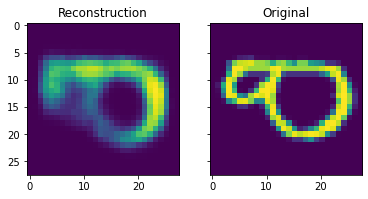

Reconstruction loss 170.85765075683594, Kullback Leibler divergence 16.342008590698242
Reconstruction loss 171.9766387939453, Kullback Leibler divergence 16.479049682617188
Reconstruction loss 164.7676239013672, Kullback Leibler divergence 16.904842376708984
Reconstruction loss 168.83563232421875, Kullback Leibler divergence 17.131065368652344
Reconstruction loss 164.5593719482422, Kullback Leibler divergence 17.375473022460938
Reconstruction loss 166.17750549316406, Kullback Leibler divergence 17.132057189941406
Reconstruction loss 177.751953125, Kullback Leibler divergence 16.651119232177734
Reconstruction loss 170.3582763671875, Kullback Leibler divergence 16.587461471557617
Reconstruction loss 162.00115966796875, Kullback Leibler divergence 16.909414291381836
Reconstruction loss 165.12046813964844, Kullback Leibler divergence 16.689973831176758


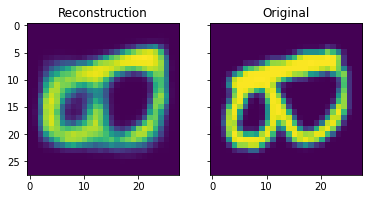

Reconstruction loss 172.57211303710938, Kullback Leibler divergence 16.4851016998291
Reconstruction loss 170.2938232421875, Kullback Leibler divergence 17.153179168701172
Reconstruction loss 175.0546875, Kullback Leibler divergence 17.387189865112305
Reconstruction loss 164.45068359375, Kullback Leibler divergence 17.351612091064453
Reconstruction loss 166.14085388183594, Kullback Leibler divergence 17.78717803955078
Reconstruction loss 158.99215698242188, Kullback Leibler divergence 17.55518341064453
Reconstruction loss 166.32643127441406, Kullback Leibler divergence 16.96470069885254
Reconstruction loss 167.90948486328125, Kullback Leibler divergence 16.496110916137695
Reconstruction loss 165.66082763671875, Kullback Leibler divergence 16.454666137695312
Reconstruction loss 159.0753936767578, Kullback Leibler divergence 16.449508666992188


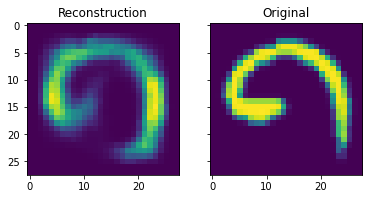

Reconstruction loss 174.92205810546875, Kullback Leibler divergence 16.573612213134766
Reconstruction loss 170.0663604736328, Kullback Leibler divergence 16.769811630249023
Reconstruction loss 175.7291259765625, Kullback Leibler divergence 16.406375885009766
Reconstruction loss 164.8722686767578, Kullback Leibler divergence 16.517473220825195
Reconstruction loss 169.41055297851562, Kullback Leibler divergence 17.241907119750977
Reconstruction loss 162.0000762939453, Kullback Leibler divergence 17.88844108581543
Reconstruction loss 164.09542846679688, Kullback Leibler divergence 17.62560272216797
Reconstruction loss 170.45045471191406, Kullback Leibler divergence 16.99396514892578
Reconstruction loss 165.39808654785156, Kullback Leibler divergence 16.745361328125
Reconstruction loss 161.6614990234375, Kullback Leibler divergence 16.2479248046875


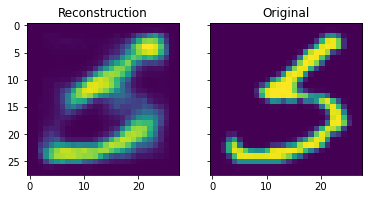

Reconstruction loss 165.24070739746094, Kullback Leibler divergence 16.177284240722656
Reconstruction loss 166.2599639892578, Kullback Leibler divergence 16.325634002685547
Reconstruction loss 170.01080322265625, Kullback Leibler divergence 16.375682830810547
Reconstruction loss 163.2382354736328, Kullback Leibler divergence 16.9791202545166
Reconstruction loss 177.7268524169922, Kullback Leibler divergence 17.21595001220703
Reconstruction loss 163.46697998046875, Kullback Leibler divergence 17.212034225463867
Reconstruction loss 161.58396911621094, Kullback Leibler divergence 17.671045303344727
Reconstruction loss 171.3975830078125, Kullback Leibler divergence 17.78310203552246
Reconstruction loss 171.64474487304688, Kullback Leibler divergence 17.129867553710938
Reconstruction loss 166.77293395996094, Kullback Leibler divergence 17.3814640045166


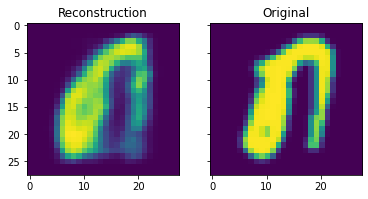

Reconstruction loss 159.3699188232422, Kullback Leibler divergence 16.713369369506836
Reconstruction loss 180.28160095214844, Kullback Leibler divergence 16.727054595947266
Reconstruction loss 169.7054901123047, Kullback Leibler divergence 16.614356994628906
Reconstruction loss 156.50779724121094, Kullback Leibler divergence 17.064481735229492
Reconstruction loss 164.6571044921875, Kullback Leibler divergence 17.33325958251953
Reconstruction loss 168.46324157714844, Kullback Leibler divergence 17.36555290222168
Reconstruction loss 167.7725067138672, Kullback Leibler divergence 16.954511642456055
Reconstruction loss 170.4515838623047, Kullback Leibler divergence 16.959205627441406
Reconstruction loss 167.02413940429688, Kullback Leibler divergence 17.699604034423828
Reconstruction loss 160.57440185546875, Kullback Leibler divergence 17.584617614746094


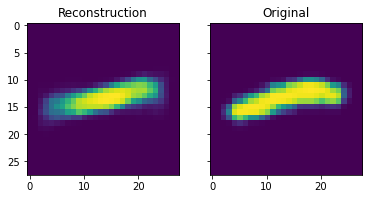

Reconstruction loss 170.5137939453125, Kullback Leibler divergence 17.648109436035156
Reconstruction loss 165.7535400390625, Kullback Leibler divergence 17.06322479248047
Reconstruction loss 168.3065948486328, Kullback Leibler divergence 16.69773292541504
Reconstruction loss 168.7960968017578, Kullback Leibler divergence 16.30255126953125
Reconstruction loss 170.38331604003906, Kullback Leibler divergence 16.449308395385742
Reconstruction loss 176.5712432861328, Kullback Leibler divergence 16.22333526611328
Reconstruction loss 167.44146728515625, Kullback Leibler divergence 16.551366806030273
Reconstruction loss 167.44766235351562, Kullback Leibler divergence 16.81099510192871
Reconstruction loss 172.2198028564453, Kullback Leibler divergence 17.611011505126953
Reconstruction loss 165.03167724609375, Kullback Leibler divergence 17.492481231689453


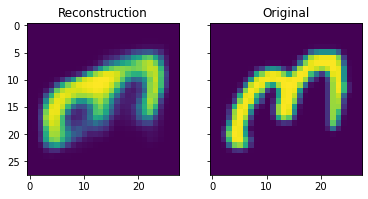

Reconstruction loss 165.76007080078125, Kullback Leibler divergence 17.651351928710938
Reconstruction loss 166.7523651123047, Kullback Leibler divergence 17.53331756591797
Reconstruction loss 173.77398681640625, Kullback Leibler divergence 18.189247131347656
Reconstruction loss 165.86097717285156, Kullback Leibler divergence 17.813810348510742
Reconstruction loss 169.5820770263672, Kullback Leibler divergence 17.15546417236328
Reconstruction loss 163.05006408691406, Kullback Leibler divergence 17.001689910888672
Reconstruction loss 164.6270294189453, Kullback Leibler divergence 16.7276611328125
Reconstruction loss 164.35394287109375, Kullback Leibler divergence 16.721845626831055
Reconstruction loss 167.8516082763672, Kullback Leibler divergence 16.881500244140625
Reconstruction loss 156.05828857421875, Kullback Leibler divergence 17.175674438476562


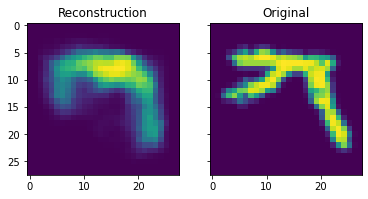

Reconstruction loss 168.55699157714844, Kullback Leibler divergence 17.548564910888672
Reconstruction loss 159.33932495117188, Kullback Leibler divergence 17.889129638671875
Reconstruction loss 166.1828155517578, Kullback Leibler divergence 17.225873947143555
Reconstruction loss 168.49415588378906, Kullback Leibler divergence 16.95146942138672
Reconstruction loss 169.5462646484375, Kullback Leibler divergence 16.694612503051758
Reconstruction loss 164.51780700683594, Kullback Leibler divergence 17.242883682250977
Reconstruction loss 166.28451538085938, Kullback Leibler divergence 17.402973175048828
Reconstruction loss 159.24374389648438, Kullback Leibler divergence 18.268585205078125
Reconstruction loss 161.09555053710938, Kullback Leibler divergence 18.450946807861328
Reconstruction loss 167.43341064453125, Kullback Leibler divergence 17.691509246826172


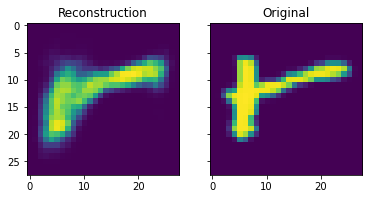

Reconstruction loss 164.3950958251953, Kullback Leibler divergence 17.19538116455078
Reconstruction loss 160.8173065185547, Kullback Leibler divergence 16.678504943847656
Reconstruction loss 162.3890838623047, Kullback Leibler divergence 16.25371551513672
Reconstruction loss 170.2694854736328, Kullback Leibler divergence 16.66044807434082
Reconstruction loss 169.96859741210938, Kullback Leibler divergence 16.86653709411621
Reconstruction loss 164.18145751953125, Kullback Leibler divergence 17.1639461517334
Reconstruction loss 166.59054565429688, Kullback Leibler divergence 17.63289451599121
Reconstruction loss 159.7369384765625, Kullback Leibler divergence 18.264644622802734
Reconstruction loss 169.9140167236328, Kullback Leibler divergence 18.195871353149414
Reconstruction loss 165.37184143066406, Kullback Leibler divergence 17.836753845214844


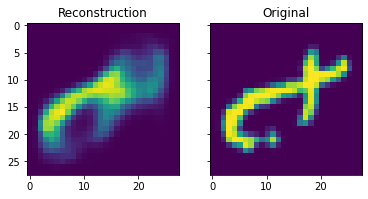

Reconstruction loss 162.39564514160156, Kullback Leibler divergence 17.02108383178711
Reconstruction loss 163.06785583496094, Kullback Leibler divergence 16.936426162719727
Reconstruction loss 166.41554260253906, Kullback Leibler divergence 17.10712432861328
Reconstruction loss 165.05819702148438, Kullback Leibler divergence 17.056245803833008
Reconstruction loss 164.2236785888672, Kullback Leibler divergence 17.10771942138672
Reconstruction loss 168.89625549316406, Kullback Leibler divergence 17.26631736755371
Reconstruction loss 164.0919189453125, Kullback Leibler divergence 16.71990394592285
Reconstruction loss 166.4628143310547, Kullback Leibler divergence 17.51111602783203
Reconstruction loss 162.32102966308594, Kullback Leibler divergence 17.572912216186523
Reconstruction loss 160.1189422607422, Kullback Leibler divergence 17.445837020874023


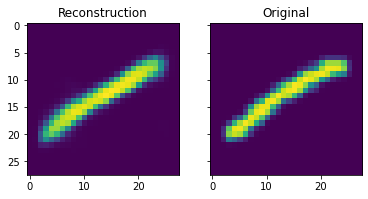

Reconstruction loss 169.80194091796875, Kullback Leibler divergence 17.833093643188477
Reconstruction loss 160.70074462890625, Kullback Leibler divergence 17.196659088134766
Reconstruction loss 167.62484741210938, Kullback Leibler divergence 17.380401611328125
Reconstruction loss 174.39703369140625, Kullback Leibler divergence 16.555862426757812
Reconstruction loss 168.4823760986328, Kullback Leibler divergence 16.900257110595703
Reconstruction loss 160.32891845703125, Kullback Leibler divergence 16.938146591186523
Reconstruction loss 170.47474670410156, Kullback Leibler divergence 17.772218704223633
Reconstruction loss 166.70965576171875, Kullback Leibler divergence 17.83124351501465
Reconstruction loss 163.6693878173828, Kullback Leibler divergence 17.902667999267578
Reconstruction loss 166.1210174560547, Kullback Leibler divergence 18.421913146972656


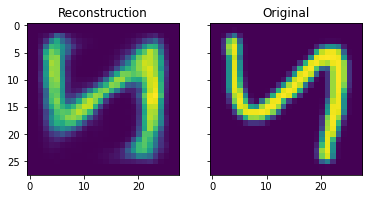

Reconstruction loss 150.43458557128906, Kullback Leibler divergence 18.198331832885742
Reconstruction loss 168.0397491455078, Kullback Leibler divergence 17.696704864501953
Reconstruction loss 163.84983825683594, Kullback Leibler divergence 16.946557998657227
Reconstruction loss 166.8635711669922, Kullback Leibler divergence 16.735145568847656
Reconstruction loss 174.00929260253906, Kullback Leibler divergence 16.958171844482422
Reconstruction loss 171.3544464111328, Kullback Leibler divergence 16.787710189819336
Reconstruction loss 158.2460479736328, Kullback Leibler divergence 17.249563217163086
Reconstruction loss 167.58999633789062, Kullback Leibler divergence 17.531660079956055
Reconstruction loss 163.0713348388672, Kullback Leibler divergence 17.214210510253906
Reconstruction loss 166.61297607421875, Kullback Leibler divergence 17.31336784362793


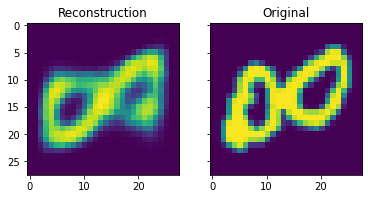

Reconstruction loss 165.8751983642578, Kullback Leibler divergence 17.942031860351562
Reconstruction loss 167.0890655517578, Kullback Leibler divergence 18.16808319091797
Reconstruction loss 156.84495544433594, Kullback Leibler divergence 18.356800079345703
Reconstruction loss 159.0321044921875, Kullback Leibler divergence 18.06304359436035
Reconstruction loss 165.82647705078125, Kullback Leibler divergence 17.913524627685547
Reconstruction loss 161.29510498046875, Kullback Leibler divergence 17.76863670349121
Reconstruction loss 157.05223083496094, Kullback Leibler divergence 17.650510787963867
Reconstruction loss 159.58160400390625, Kullback Leibler divergence 17.74513816833496
Reconstruction loss 165.0550537109375, Kullback Leibler divergence 18.199682235717773
Reconstruction loss 163.8381805419922, Kullback Leibler divergence 18.029190063476562


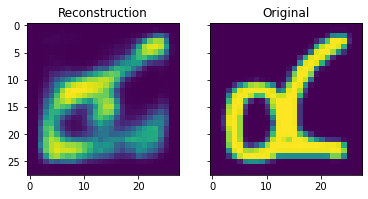

Reconstruction loss 162.0539093017578, Kullback Leibler divergence 17.713397979736328
Reconstruction loss 161.5811309814453, Kullback Leibler divergence 17.179935455322266
Reconstruction loss 168.30455017089844, Kullback Leibler divergence 17.1372127532959
Reconstruction loss 156.31593322753906, Kullback Leibler divergence 16.560504913330078
Reconstruction loss 160.51397705078125, Kullback Leibler divergence 16.47225570678711
Reconstruction loss 166.98875427246094, Kullback Leibler divergence 16.522781372070312
Reconstruction loss 175.16757202148438, Kullback Leibler divergence 17.606966018676758
Reconstruction loss 157.86663818359375, Kullback Leibler divergence 17.7032527923584
Reconstruction loss 159.3993682861328, Kullback Leibler divergence 18.210432052612305
Reconstruction loss 160.7916259765625, Kullback Leibler divergence 18.306642532348633


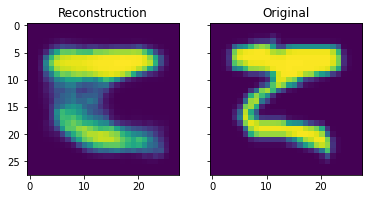

Reconstruction loss 164.51051330566406, Kullback Leibler divergence 17.698070526123047
Reconstruction loss 157.0764923095703, Kullback Leibler divergence 18.366300582885742
Reconstruction loss 160.33412170410156, Kullback Leibler divergence 18.181373596191406
Reconstruction loss 159.993896484375, Kullback Leibler divergence 18.227222442626953
Reconstruction loss 169.6102294921875, Kullback Leibler divergence 17.86324119567871
Reconstruction loss 162.81878662109375, Kullback Leibler divergence 17.028657913208008
Reconstruction loss 162.3109893798828, Kullback Leibler divergence 16.79061508178711
Reconstruction loss 162.93331909179688, Kullback Leibler divergence 16.983945846557617
Reconstruction loss 167.84429931640625, Kullback Leibler divergence 17.71198272705078
Reconstruction loss 159.7238006591797, Kullback Leibler divergence 18.364864349365234


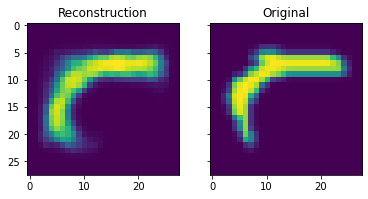

Reconstruction loss 158.1191864013672, Kullback Leibler divergence 18.39795684814453
Reconstruction loss 169.9659423828125, Kullback Leibler divergence 18.36543083190918
Reconstruction loss 156.9097442626953, Kullback Leibler divergence 18.062942504882812
Reconstruction loss 159.03549194335938, Kullback Leibler divergence 18.036314010620117
Reconstruction loss 168.00216674804688, Kullback Leibler divergence 17.767650604248047
Reconstruction loss 161.6961669921875, Kullback Leibler divergence 17.633956909179688
Reconstruction loss 157.67703247070312, Kullback Leibler divergence 17.534082412719727
Reconstruction loss 154.20640563964844, Kullback Leibler divergence 18.01738929748535
Reconstruction loss 172.8876953125, Kullback Leibler divergence 18.194652557373047
Reconstruction loss 167.08372497558594, Kullback Leibler divergence 18.643657684326172


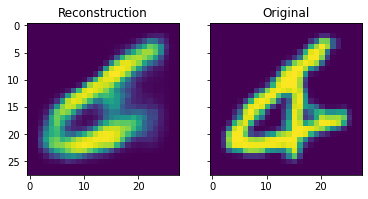

Reconstruction loss 156.1383056640625, Kullback Leibler divergence 17.935501098632812
Reconstruction loss 163.49708557128906, Kullback Leibler divergence 17.495054244995117
Reconstruction loss 164.00437927246094, Kullback Leibler divergence 17.382587432861328
Reconstruction loss 164.16831970214844, Kullback Leibler divergence 18.10869598388672
Reconstruction loss 160.26190185546875, Kullback Leibler divergence 18.204395294189453
Reconstruction loss 165.69784545898438, Kullback Leibler divergence 18.314027786254883
Reconstruction loss 163.32070922851562, Kullback Leibler divergence 17.747072219848633
Reconstruction loss 159.23548889160156, Kullback Leibler divergence 17.74030303955078
Reconstruction loss 168.2447052001953, Kullback Leibler divergence 17.708349227905273
Reconstruction loss 161.72828674316406, Kullback Leibler divergence 17.757078170776367


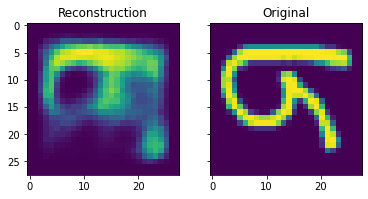

Reconstruction loss 161.5598907470703, Kullback Leibler divergence 17.60076141357422
Reconstruction loss 164.49407958984375, Kullback Leibler divergence 17.831497192382812
Reconstruction loss 155.02383422851562, Kullback Leibler divergence 18.90293312072754
Reconstruction loss 159.55288696289062, Kullback Leibler divergence 19.685585021972656
Reconstruction loss 160.12608337402344, Kullback Leibler divergence 20.059263229370117
Reconstruction loss 159.90789794921875, Kullback Leibler divergence 18.937551498413086
Reconstruction loss 159.18882751464844, Kullback Leibler divergence 18.15442657470703
Reconstruction loss 166.06875610351562, Kullback Leibler divergence 17.904722213745117
Reconstruction loss 167.03761291503906, Kullback Leibler divergence 17.78899383544922
Reconstruction loss 166.52020263671875, Kullback Leibler divergence 18.043052673339844


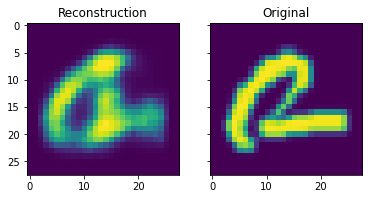

Reconstruction loss 159.96209716796875, Kullback Leibler divergence 18.139753341674805
Reconstruction loss 165.89576721191406, Kullback Leibler divergence 18.28502655029297
Reconstruction loss 167.6519317626953, Kullback Leibler divergence 18.205936431884766
Reconstruction loss 164.89781188964844, Kullback Leibler divergence 17.667970657348633
Reconstruction loss 164.1983184814453, Kullback Leibler divergence 18.141218185424805
Reconstruction loss 162.1529541015625, Kullback Leibler divergence 17.870262145996094
Reconstruction loss 162.96824645996094, Kullback Leibler divergence 17.896846771240234
Reconstruction loss 158.0603790283203, Kullback Leibler divergence 18.17998504638672
Reconstruction loss 164.50173950195312, Kullback Leibler divergence 18.313756942749023
Reconstruction loss 167.22377014160156, Kullback Leibler divergence 18.751598358154297


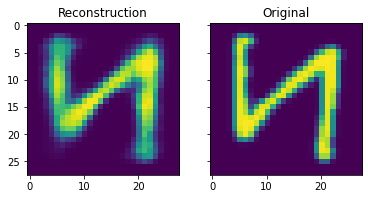

Reconstruction loss 166.30258178710938, Kullback Leibler divergence 17.831645965576172
Reconstruction loss 163.49082946777344, Kullback Leibler divergence 17.635025024414062
Reconstruction loss 161.7021484375, Kullback Leibler divergence 17.50876808166504
Reconstruction loss 156.67185974121094, Kullback Leibler divergence 17.20445442199707
Reconstruction loss 163.45960998535156, Kullback Leibler divergence 18.299285888671875
Reconstruction loss 166.70945739746094, Kullback Leibler divergence 18.72869300842285
Reconstruction loss 162.53871154785156, Kullback Leibler divergence 18.40618133544922
Reconstruction loss 162.84945678710938, Kullback Leibler divergence 18.3100528717041
Reconstruction loss 161.27003479003906, Kullback Leibler divergence 18.401945114135742
Reconstruction loss 154.96429443359375, Kullback Leibler divergence 18.740507125854492


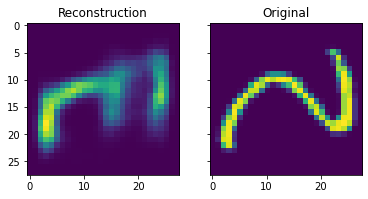

Reconstruction loss 168.44570922851562, Kullback Leibler divergence 18.263460159301758
Reconstruction loss 164.64297485351562, Kullback Leibler divergence 18.8057861328125
Reconstruction loss 160.58831787109375, Kullback Leibler divergence 18.381559371948242
Reconstruction loss 161.2967071533203, Kullback Leibler divergence 18.607666015625
Reconstruction loss 155.1792449951172, Kullback Leibler divergence 18.213485717773438
Reconstruction loss 164.2217559814453, Kullback Leibler divergence 18.292442321777344
Reconstruction loss 160.87709045410156, Kullback Leibler divergence 18.11786651611328
Reconstruction loss 159.68667602539062, Kullback Leibler divergence 18.222423553466797
Reconstruction loss 165.49363708496094, Kullback Leibler divergence 17.47339630126953
Reconstruction loss 163.58811950683594, Kullback Leibler divergence 18.04621696472168


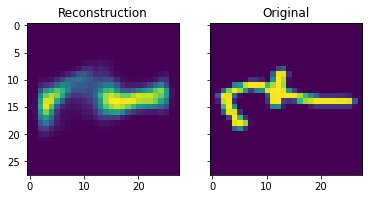

Reconstruction loss 157.85235595703125, Kullback Leibler divergence 18.1408634185791
Reconstruction loss 158.6550750732422, Kullback Leibler divergence 18.564231872558594
Reconstruction loss 152.5619659423828, Kullback Leibler divergence 18.496170043945312
Reconstruction loss 165.03253173828125, Kullback Leibler divergence 19.053022384643555
Reconstruction loss 158.1990203857422, Kullback Leibler divergence 19.185731887817383
Reconstruction loss 154.64158630371094, Kullback Leibler divergence 18.996349334716797
Reconstruction loss 163.79153442382812, Kullback Leibler divergence 18.970203399658203
Reconstruction loss 156.42501831054688, Kullback Leibler divergence 17.874664306640625
Reconstruction loss 160.18215942382812, Kullback Leibler divergence 17.914060592651367
Reconstruction loss 159.9336700439453, Kullback Leibler divergence 17.983165740966797


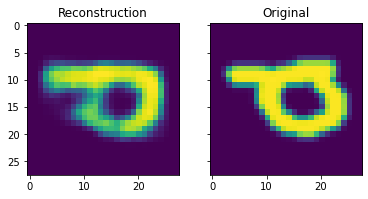

Reconstruction loss 155.19212341308594, Kullback Leibler divergence 18.577564239501953
Reconstruction loss 158.9766082763672, Kullback Leibler divergence 18.94974136352539
Reconstruction loss 156.41419982910156, Kullback Leibler divergence 18.505752563476562
Reconstruction loss 158.06536865234375, Kullback Leibler divergence 18.44089698791504
Reconstruction loss 154.47972106933594, Kullback Leibler divergence 17.954381942749023
Reconstruction loss 162.78411865234375, Kullback Leibler divergence 18.2355899810791
Reconstruction loss 154.9840850830078, Kullback Leibler divergence 18.434507369995117
Reconstruction loss 160.63226318359375, Kullback Leibler divergence 18.786476135253906
Reconstruction loss 163.45831298828125, Kullback Leibler divergence 18.483797073364258
Reconstruction loss 160.1389923095703, Kullback Leibler divergence 18.736852645874023


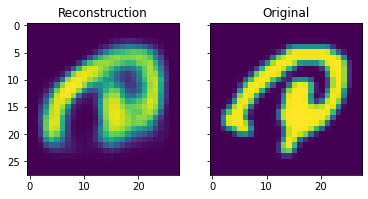

Reconstruction loss 153.49603271484375, Kullback Leibler divergence 18.515291213989258
Reconstruction loss 162.86419677734375, Kullback Leibler divergence 18.057456970214844
Reconstruction loss 164.3642120361328, Kullback Leibler divergence 18.042278289794922
Reconstruction loss 160.41000366210938, Kullback Leibler divergence 18.203617095947266
Reconstruction loss 164.05238342285156, Kullback Leibler divergence 18.823240280151367
Reconstruction loss 163.10003662109375, Kullback Leibler divergence 18.58734130859375
Reconstruction loss 153.51556396484375, Kullback Leibler divergence 18.979473114013672
Reconstruction loss 155.0917510986328, Kullback Leibler divergence 18.89641761779785
Reconstruction loss 163.97821044921875, Kullback Leibler divergence 18.03434944152832
Reconstruction loss 151.76206970214844, Kullback Leibler divergence 17.755605697631836


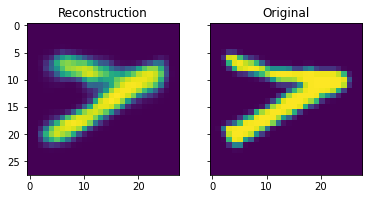

Reconstruction loss 161.55613708496094, Kullback Leibler divergence 17.665660858154297
Reconstruction loss 167.38206481933594, Kullback Leibler divergence 18.195465087890625
Reconstruction loss 155.1997528076172, Kullback Leibler divergence 19.112367630004883
Reconstruction loss 159.49752807617188, Kullback Leibler divergence 19.747879028320312
Reconstruction loss 155.3879852294922, Kullback Leibler divergence 19.733013153076172
Reconstruction loss 148.66177368164062, Kullback Leibler divergence 19.058778762817383
Reconstruction loss 156.15208435058594, Kullback Leibler divergence 18.38555145263672
Reconstruction loss 156.23971557617188, Kullback Leibler divergence 18.167884826660156
Reconstruction loss 156.91607666015625, Kullback Leibler divergence 18.39149284362793
Reconstruction loss 150.36660766601562, Kullback Leibler divergence 18.392414093017578


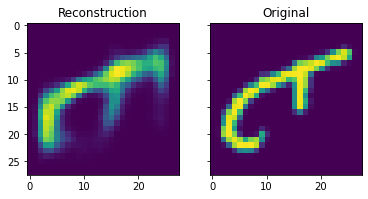

Reconstruction loss 162.25320434570312, Kullback Leibler divergence 18.258169174194336
Reconstruction loss 156.94947814941406, Kullback Leibler divergence 18.871021270751953
Reconstruction loss 159.68072509765625, Kullback Leibler divergence 18.6071834564209
Reconstruction loss 163.7572784423828, Kullback Leibler divergence 18.43768882751465
Reconstruction loss 159.21656799316406, Kullback Leibler divergence 18.31671905517578
Reconstruction loss 156.3887176513672, Kullback Leibler divergence 18.181684494018555
Reconstruction loss 158.384765625, Kullback Leibler divergence 18.719139099121094
Reconstruction loss 151.9560546875, Kullback Leibler divergence 19.02716636657715
Reconstruction loss 153.33518981933594, Kullback Leibler divergence 19.789928436279297
Reconstruction loss 149.95140075683594, Kullback Leibler divergence 18.803234100341797


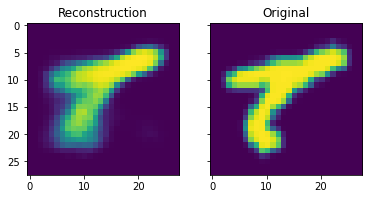

Reconstruction loss 160.47247314453125, Kullback Leibler divergence 18.667966842651367
Reconstruction loss 158.1626434326172, Kullback Leibler divergence 17.500713348388672
Reconstruction loss 152.37091064453125, Kullback Leibler divergence 17.14429473876953
Reconstruction loss 160.68539428710938, Kullback Leibler divergence 17.275869369506836
Reconstruction loss 155.34457397460938, Kullback Leibler divergence 18.253273010253906
Reconstruction loss 156.00584411621094, Kullback Leibler divergence 19.22690773010254
Reconstruction loss 153.42674255371094, Kullback Leibler divergence 19.68543243408203
Reconstruction loss 155.30258178710938, Kullback Leibler divergence 19.84376335144043
Reconstruction loss 152.628662109375, Kullback Leibler divergence 19.611188888549805
Reconstruction loss 160.5467529296875, Kullback Leibler divergence 19.115501403808594


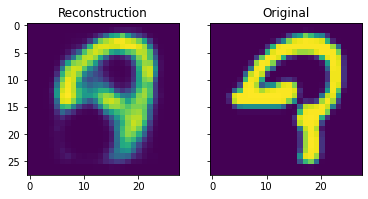

Reconstruction loss 153.2484130859375, Kullback Leibler divergence 18.560588836669922
Reconstruction loss 158.36329650878906, Kullback Leibler divergence 18.639415740966797
Reconstruction loss 150.99595642089844, Kullback Leibler divergence 18.700010299682617
Reconstruction loss 152.0516357421875, Kullback Leibler divergence 19.086645126342773
Reconstruction loss 164.88192749023438, Kullback Leibler divergence 19.148395538330078
Reconstruction loss 157.33131408691406, Kullback Leibler divergence 18.554454803466797
Reconstruction loss 156.39186096191406, Kullback Leibler divergence 18.357702255249023
Reconstruction loss 161.60293579101562, Kullback Leibler divergence 18.32684326171875
Reconstruction loss 146.5896453857422, Kullback Leibler divergence 18.467147827148438
Reconstruction loss 162.55401611328125, Kullback Leibler divergence 18.91084098815918


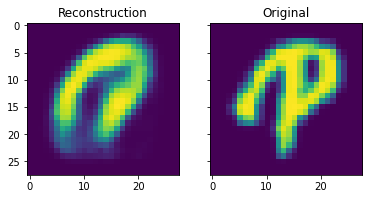

Reconstruction loss 162.54811096191406, Kullback Leibler divergence 18.931596755981445
Reconstruction loss 156.77597045898438, Kullback Leibler divergence 18.410472869873047
Reconstruction loss 161.30397033691406, Kullback Leibler divergence 18.764554977416992
Reconstruction loss 166.04344177246094, Kullback Leibler divergence 18.668458938598633
Reconstruction loss 158.6065673828125, Kullback Leibler divergence 18.60559844970703
Reconstruction loss 149.42318725585938, Kullback Leibler divergence 18.495134353637695
Reconstruction loss 148.64761352539062, Kullback Leibler divergence 18.63909149169922
Reconstruction loss 154.0700225830078, Kullback Leibler divergence 19.280946731567383
Reconstruction loss 150.2491912841797, Kullback Leibler divergence 18.86391258239746
Reconstruction loss 151.69552612304688, Kullback Leibler divergence 18.66107940673828


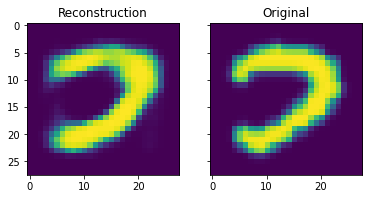

Reconstruction loss 149.70266723632812, Kullback Leibler divergence 18.921154022216797
Reconstruction loss 153.24546813964844, Kullback Leibler divergence 18.536821365356445
Reconstruction loss 149.6578369140625, Kullback Leibler divergence 18.64629554748535
Reconstruction loss 163.31381225585938, Kullback Leibler divergence 18.18184471130371
Reconstruction loss 154.7688446044922, Kullback Leibler divergence 18.577810287475586
Reconstruction loss 161.97007751464844, Kullback Leibler divergence 18.825559616088867
Reconstruction loss 166.13873291015625, Kullback Leibler divergence 19.325742721557617
Reconstruction loss 151.78256225585938, Kullback Leibler divergence 19.233768463134766
Reconstruction loss 157.4084930419922, Kullback Leibler divergence 18.893518447875977
Reconstruction loss 152.9022979736328, Kullback Leibler divergence 18.567060470581055


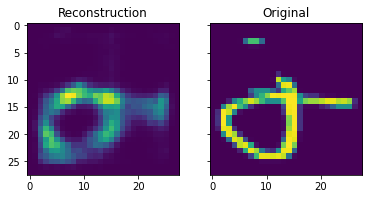

Reconstruction loss 163.94580078125, Kullback Leibler divergence 19.27465057373047
Reconstruction loss 157.1042022705078, Kullback Leibler divergence 19.273151397705078
Reconstruction loss 157.38580322265625, Kullback Leibler divergence 18.991422653198242
Reconstruction loss 158.89739990234375, Kullback Leibler divergence 19.2194881439209
Reconstruction loss 156.79840087890625, Kullback Leibler divergence 19.703474044799805
Reconstruction loss 154.71922302246094, Kullback Leibler divergence 19.282007217407227
Reconstruction loss 154.27377319335938, Kullback Leibler divergence 18.308374404907227
Reconstruction loss 150.7223663330078, Kullback Leibler divergence 17.777782440185547
Reconstruction loss 155.48167419433594, Kullback Leibler divergence 17.41083526611328
Reconstruction loss 161.46482849121094, Kullback Leibler divergence 17.69060516357422


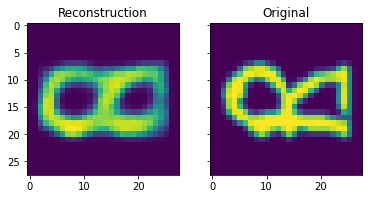

Reconstruction loss 157.3402099609375, Kullback Leibler divergence 18.334196090698242
Reconstruction loss 153.1250457763672, Kullback Leibler divergence 18.89842987060547
Reconstruction loss 150.51763916015625, Kullback Leibler divergence 19.424596786499023
Reconstruction loss 162.4058837890625, Kullback Leibler divergence 19.04129409790039
Reconstruction loss 151.91500854492188, Kullback Leibler divergence 18.463197708129883
Reconstruction loss 158.3516387939453, Kullback Leibler divergence 18.57599449157715
Reconstruction loss 161.57908630371094, Kullback Leibler divergence 18.01576042175293
Reconstruction loss 160.82691955566406, Kullback Leibler divergence 18.459257125854492
Reconstruction loss 149.9180450439453, Kullback Leibler divergence 19.098464965820312
Reconstruction loss 155.32894897460938, Kullback Leibler divergence 19.440820693969727


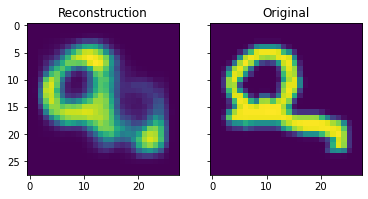

Reconstruction loss 158.1193084716797, Kullback Leibler divergence 19.935474395751953
Reconstruction loss 151.05047607421875, Kullback Leibler divergence 19.407506942749023
Reconstruction loss 157.19505310058594, Kullback Leibler divergence 19.108875274658203
Reconstruction loss 162.6848907470703, Kullback Leibler divergence 18.694290161132812
Reconstruction loss 158.12179565429688, Kullback Leibler divergence 18.491491317749023
Reconstruction loss 155.1904754638672, Kullback Leibler divergence 18.279773712158203
Reconstruction loss 151.8624267578125, Kullback Leibler divergence 18.479286193847656
Reconstruction loss 157.09837341308594, Kullback Leibler divergence 18.898921966552734
Reconstruction loss 153.33497619628906, Kullback Leibler divergence 19.05806541442871
Reconstruction loss 157.02822875976562, Kullback Leibler divergence 19.156620025634766


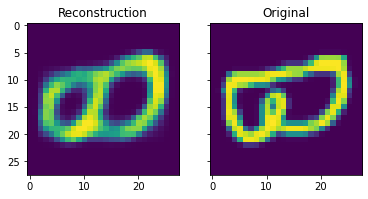

Reconstruction loss 153.0350799560547, Kullback Leibler divergence 19.297252655029297
Reconstruction loss 155.24673461914062, Kullback Leibler divergence 19.476272583007812
Reconstruction loss 152.45590209960938, Kullback Leibler divergence 19.52324676513672
Reconstruction loss 148.08753967285156, Kullback Leibler divergence 18.86762237548828
Reconstruction loss 158.27423095703125, Kullback Leibler divergence 18.504819869995117
Reconstruction loss 158.71600341796875, Kullback Leibler divergence 18.487241744995117
Reconstruction loss 148.82681274414062, Kullback Leibler divergence 18.219091415405273
Reconstruction loss 151.7438507080078, Kullback Leibler divergence 18.440223693847656
Reconstruction loss 159.7388458251953, Kullback Leibler divergence 19.046045303344727
Reconstruction loss 153.01596069335938, Kullback Leibler divergence 19.36882972717285


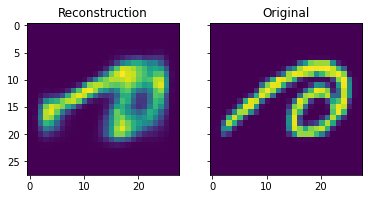

Reconstruction loss 151.32469177246094, Kullback Leibler divergence 19.69452476501465
Reconstruction loss 153.0392608642578, Kullback Leibler divergence 18.8154354095459
Reconstruction loss 152.64097595214844, Kullback Leibler divergence 18.868677139282227
Reconstruction loss 155.50277709960938, Kullback Leibler divergence 18.63086700439453
Reconstruction loss 156.97177124023438, Kullback Leibler divergence 19.59984016418457
Reconstruction loss 148.49880981445312, Kullback Leibler divergence 20.207347869873047
Reconstruction loss 152.38973999023438, Kullback Leibler divergence 19.96935272216797
Reconstruction loss 149.7619171142578, Kullback Leibler divergence 19.537996292114258
Reconstruction loss 148.34652709960938, Kullback Leibler divergence 18.578866958618164
Reconstruction loss 149.8475341796875, Kullback Leibler divergence 17.909990310668945


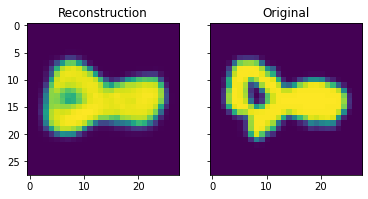

Reconstruction loss 155.27743530273438, Kullback Leibler divergence 18.556411743164062
Reconstruction loss 157.85452270507812, Kullback Leibler divergence 19.193077087402344
Reconstruction loss 147.8435516357422, Kullback Leibler divergence 19.638952255249023
Reconstruction loss 154.67832946777344, Kullback Leibler divergence 19.949203491210938
Reconstruction loss 154.32290649414062, Kullback Leibler divergence 20.117183685302734
Reconstruction loss 154.8334503173828, Kullback Leibler divergence 19.761798858642578
Reconstruction loss 156.2047119140625, Kullback Leibler divergence 18.843395233154297
Reconstruction loss 154.6396942138672, Kullback Leibler divergence 18.529905319213867
Reconstruction loss 149.30845642089844, Kullback Leibler divergence 18.596637725830078
Reconstruction loss 155.12574768066406, Kullback Leibler divergence 19.007238388061523


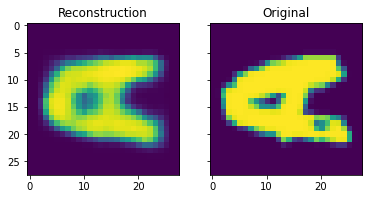

Reconstruction loss 158.5896453857422, Kullback Leibler divergence 19.55608367919922
Reconstruction loss 157.1842803955078, Kullback Leibler divergence 19.681127548217773
Reconstruction loss 146.02821350097656, Kullback Leibler divergence 19.647279739379883
Reconstruction loss 160.71197509765625, Kullback Leibler divergence 19.35187530517578
Reconstruction loss 153.14010620117188, Kullback Leibler divergence 19.103649139404297
Reconstruction loss 156.95382690429688, Kullback Leibler divergence 19.249650955200195
Reconstruction loss 164.13365173339844, Kullback Leibler divergence 19.822956085205078
Reconstruction loss 160.5144805908203, Kullback Leibler divergence 20.192180633544922
Reconstruction loss 145.4849090576172, Kullback Leibler divergence 19.4860897064209
Reconstruction loss 147.5897216796875, Kullback Leibler divergence 19.345365524291992


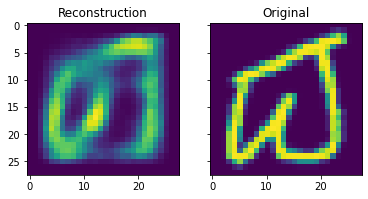

Reconstruction loss 162.0846710205078, Kullback Leibler divergence 19.949548721313477
Reconstruction loss 158.93133544921875, Kullback Leibler divergence 19.412290573120117
Reconstruction loss 158.80886840820312, Kullback Leibler divergence 19.083263397216797
Reconstruction loss 155.69161987304688, Kullback Leibler divergence 18.998205184936523
Reconstruction loss 155.1778564453125, Kullback Leibler divergence 19.283872604370117
Reconstruction loss 150.50099182128906, Kullback Leibler divergence 19.412765502929688
Reconstruction loss 158.10821533203125, Kullback Leibler divergence 19.18846321105957
Reconstruction loss 162.98390197753906, Kullback Leibler divergence 19.02467155456543
Reconstruction loss 151.35479736328125, Kullback Leibler divergence 19.215364456176758
Reconstruction loss 146.82395935058594, Kullback Leibler divergence 19.331987380981445


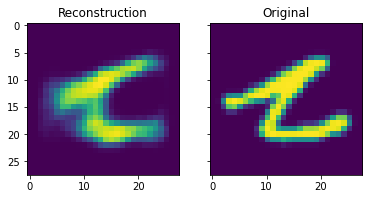

Reconstruction loss 148.77947998046875, Kullback Leibler divergence 19.408552169799805
Reconstruction loss 149.84767150878906, Kullback Leibler divergence 19.663724899291992
Reconstruction loss 162.07345581054688, Kullback Leibler divergence 19.567142486572266
Reconstruction loss 154.1508331298828, Kullback Leibler divergence 19.149377822875977
Reconstruction loss 148.0128936767578, Kullback Leibler divergence 19.475872039794922
Reconstruction loss 139.4700469970703, Kullback Leibler divergence 19.675630569458008
Reconstruction loss 151.65145874023438, Kullback Leibler divergence 19.631027221679688
Reconstruction loss 156.17942810058594, Kullback Leibler divergence 20.070171356201172
Reconstruction loss 156.92367553710938, Kullback Leibler divergence 19.640241622924805
Reconstruction loss 152.44898986816406, Kullback Leibler divergence 19.193161010742188


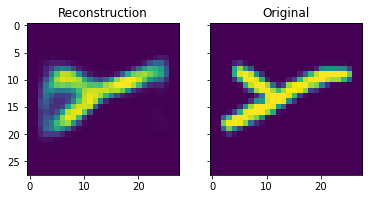

Reconstruction loss 152.02719116210938, Kullback Leibler divergence 18.876724243164062
Reconstruction loss 160.93096923828125, Kullback Leibler divergence 19.283397674560547
Reconstruction loss 152.74862670898438, Kullback Leibler divergence 19.6685733795166
Reconstruction loss 150.83035278320312, Kullback Leibler divergence 20.298294067382812
Reconstruction loss 150.41741943359375, Kullback Leibler divergence 20.3369083404541
Reconstruction loss 152.83148193359375, Kullback Leibler divergence 20.1317081451416
Reconstruction loss 142.71485900878906, Kullback Leibler divergence 19.5360050201416
Reconstruction loss 145.732421875, Kullback Leibler divergence 19.492393493652344
Reconstruction loss 157.17410278320312, Kullback Leibler divergence 19.70929527282715
Reconstruction loss 158.67311096191406, Kullback Leibler divergence 19.4699764251709


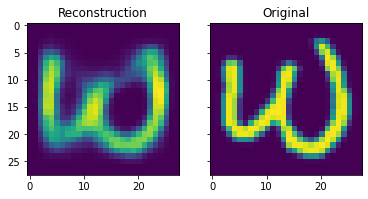

Reconstruction loss 149.93984985351562, Kullback Leibler divergence 19.810392379760742
Reconstruction loss 152.91860961914062, Kullback Leibler divergence 20.231599807739258
Reconstruction loss 153.37008666992188, Kullback Leibler divergence 19.405521392822266
Reconstruction loss 150.3056640625, Kullback Leibler divergence 18.96510887145996
Reconstruction loss 151.3889617919922, Kullback Leibler divergence 18.858470916748047
Reconstruction loss 155.95045471191406, Kullback Leibler divergence 19.756629943847656
Reconstruction loss 152.54806518554688, Kullback Leibler divergence 20.120891571044922
Reconstruction loss 148.70555114746094, Kullback Leibler divergence 20.4663143157959
Reconstruction loss 156.2750244140625, Kullback Leibler divergence 20.679590225219727
Reconstruction loss 152.34585571289062, Kullback Leibler divergence 19.950397491455078


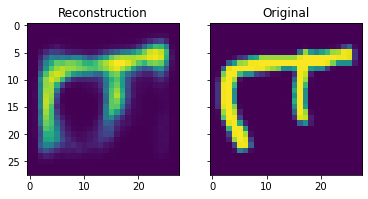

Reconstruction loss 155.76979064941406, Kullback Leibler divergence 19.819469451904297
Reconstruction loss 150.19468688964844, Kullback Leibler divergence 19.257041931152344
Reconstruction loss 149.41030883789062, Kullback Leibler divergence 19.77071762084961
Reconstruction loss 151.75144958496094, Kullback Leibler divergence 20.475200653076172
Reconstruction loss 155.2181396484375, Kullback Leibler divergence 20.303686141967773
Reconstruction loss 144.46595764160156, Kullback Leibler divergence 19.950220108032227
Reconstruction loss 159.57147216796875, Kullback Leibler divergence 19.52975082397461
Reconstruction loss 155.66336059570312, Kullback Leibler divergence 19.042692184448242
Reconstruction loss 145.77081298828125, Kullback Leibler divergence 19.382423400878906
Reconstruction loss 159.52099609375, Kullback Leibler divergence 19.813276290893555


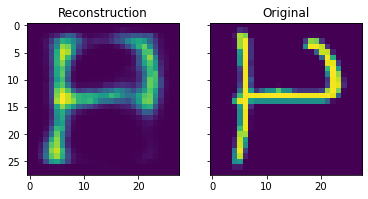

Reconstruction loss 153.78465270996094, Kullback Leibler divergence 19.62540054321289
Reconstruction loss 148.4910125732422, Kullback Leibler divergence 19.808582305908203
Reconstruction loss 159.81398010253906, Kullback Leibler divergence 19.545326232910156
Reconstruction loss 147.26577758789062, Kullback Leibler divergence 19.676029205322266
Reconstruction loss 159.18930053710938, Kullback Leibler divergence 19.390649795532227
Reconstruction loss 155.3813018798828, Kullback Leibler divergence 19.357624053955078
Reconstruction loss 156.34181213378906, Kullback Leibler divergence 19.110658645629883
Reconstruction loss 149.1807861328125, Kullback Leibler divergence 19.233837127685547
Reconstruction loss 160.32281494140625, Kullback Leibler divergence 19.792394638061523
Reconstruction loss 151.2108154296875, Kullback Leibler divergence 19.526519775390625


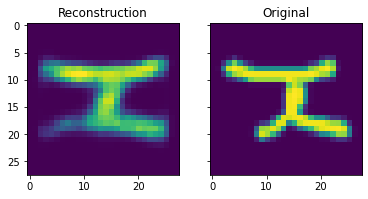

Reconstruction loss 155.3479766845703, Kullback Leibler divergence 19.447242736816406
Reconstruction loss 153.78955078125, Kullback Leibler divergence 19.711889266967773
Reconstruction loss 146.34954833984375, Kullback Leibler divergence 20.0342960357666
Reconstruction loss 152.86131286621094, Kullback Leibler divergence 20.36707305908203
Reconstruction loss 152.0803680419922, Kullback Leibler divergence 20.085981369018555
Reconstruction loss 149.30174255371094, Kullback Leibler divergence 19.701343536376953
Reconstruction loss 146.13946533203125, Kullback Leibler divergence 19.182043075561523
Reconstruction loss 155.3578643798828, Kullback Leibler divergence 19.603031158447266
Reconstruction loss 146.9341278076172, Kullback Leibler divergence 19.168113708496094
Reconstruction loss 149.74009704589844, Kullback Leibler divergence 19.063596725463867


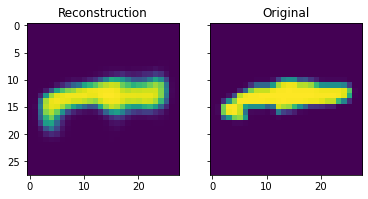

Reconstruction loss 158.89256286621094, Kullback Leibler divergence 20.034812927246094
Reconstruction loss 154.07086181640625, Kullback Leibler divergence 20.990468978881836
Reconstruction loss 151.37278747558594, Kullback Leibler divergence 20.717485427856445
Reconstruction loss 153.0355987548828, Kullback Leibler divergence 19.86134910583496
Reconstruction loss 153.08349609375, Kullback Leibler divergence 19.40909194946289
Reconstruction loss 159.5511474609375, Kullback Leibler divergence 19.404220581054688
Reconstruction loss 156.20193481445312, Kullback Leibler divergence 19.654150009155273
Reconstruction loss 146.18466186523438, Kullback Leibler divergence 19.9381046295166
Reconstruction loss 149.3256072998047, Kullback Leibler divergence 19.584871292114258
Reconstruction loss 154.81182861328125, Kullback Leibler divergence 19.637449264526367


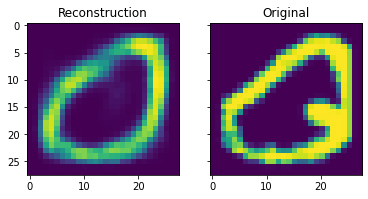

Reconstruction loss 158.4010772705078, Kullback Leibler divergence 19.478641510009766
Reconstruction loss 160.67132568359375, Kullback Leibler divergence 19.528057098388672
Reconstruction loss 149.74639892578125, Kullback Leibler divergence 19.757099151611328
Reconstruction loss 148.16107177734375, Kullback Leibler divergence 20.230619430541992
Reconstruction loss 145.80349731445312, Kullback Leibler divergence 20.322126388549805
Reconstruction loss 156.0485382080078, Kullback Leibler divergence 19.468597412109375
Reconstruction loss 155.86734008789062, Kullback Leibler divergence 19.655427932739258
Reconstruction loss 151.52928161621094, Kullback Leibler divergence 19.583826065063477
Reconstruction loss 146.24977111816406, Kullback Leibler divergence 19.845623016357422
Reconstruction loss 156.31178283691406, Kullback Leibler divergence 20.635778427124023


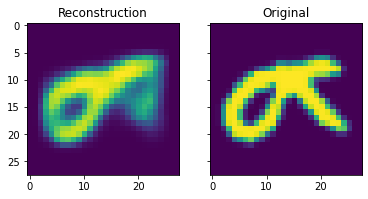

Reconstruction loss 150.58482360839844, Kullback Leibler divergence 20.36469078063965
Reconstruction loss 156.74400329589844, Kullback Leibler divergence 20.066917419433594
Reconstruction loss 152.43650817871094, Kullback Leibler divergence 20.252941131591797
Reconstruction loss 146.58554077148438, Kullback Leibler divergence 21.033979415893555
Reconstruction loss 150.09727478027344, Kullback Leibler divergence 21.107982635498047
Reconstruction loss 151.45314025878906, Kullback Leibler divergence 20.496809005737305
Reconstruction loss 157.43243408203125, Kullback Leibler divergence 19.862773895263672
Reconstruction loss 148.0075225830078, Kullback Leibler divergence 19.80643653869629
Reconstruction loss 150.43453979492188, Kullback Leibler divergence 20.210350036621094
Reconstruction loss 151.20960998535156, Kullback Leibler divergence 20.522239685058594


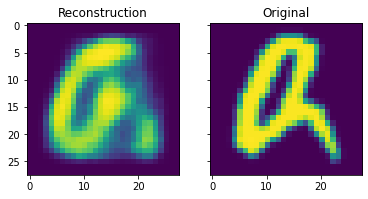

Reconstruction loss 148.2199249267578, Kullback Leibler divergence 20.131311416625977
Reconstruction loss 145.8412628173828, Kullback Leibler divergence 19.452024459838867
Reconstruction loss 153.30233764648438, Kullback Leibler divergence 20.05394172668457
Reconstruction loss 146.33480834960938, Kullback Leibler divergence 19.872007369995117
Reconstruction loss 152.36399841308594, Kullback Leibler divergence 20.355424880981445
Reconstruction loss 157.1663818359375, Kullback Leibler divergence 20.876073837280273
Reconstruction loss 148.4710693359375, Kullback Leibler divergence 20.336565017700195


In [6]:
recon_loss = np.inf
i = 0
while recon_loss > 160:
    i += 1
    print("epoch {}".format(i))
    for batch_idx, (images, _) in enumerate(data_loader):
        optimizer.zero_grad()

        images, labels = next(iter(data_loader))

        # autoencode
        reconstructions, z_means, z_stds, samples_latent = myVAE(images)

        # compute the losses, i.e. measure the difference between (input =) target and output distribtuion
        recon_loss = F.binary_cross_entropy(
            reconstructions, target=images, reduction="sum")/mb_size
        # here we couls also use the mse loss
        #recon_loss = mse(images, reconstructions)/mb_size

        # Kullback-Leibler Divergence for penalizing the posterior p(z|x) being different from N(0,1)
        # the formula below is provided for a diagonal covariance matrix
        log_var_z = torch.log(torch.pow(z_stds, 2))
        kl_loss = (-0.5*(1+log_var_z - z_means**2 -
                   torch.exp(log_var_z)).sum(dim=1)).mean(dim=0)
        print("Reconstruction loss {}, Kullback Leibler divergence {}".format(
            recon_loss, kl_loss))
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            ax1.imshow(reconstructions[0].squeeze(0).detach().numpy())
            ax1.set_title('Reconstruction')
            ax2.set_title('Original')
            ax2.imshow(images[0].squeeze(0).detach().numpy())
            plt.show()

## Sampling from the Latent Distribution

Let us first find where a random training example lies in the latent space:

label 26


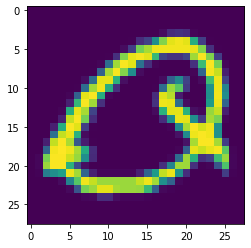

tensor([ 0.8484,  0.2414, -0.3478,  0.6965, -1.3754, -0.6269,  0.0328, -0.0994,
        -1.0405, -1.3983, -0.3473,  1.5368], grad_fn=<SqueezeBackward1>)


In [40]:
idx = np.random.randint(100)
plt.imshow(training_data[idx][0].squeeze(0).numpy())
print("label {}".format(training_data[idx][1]))
plt.show()
means, std, sample = myVAE.encoder.encode(training_data[idx][0].unsqueeze(0))
print(means.squeeze(0))

Now we can generate a sample form this point in the latent space and see whether it is similar to the training example above:

random latent state [[[ 0.87310696  0.09868522 -0.36628202  0.46422958 -1.4971359
   -0.36840263  0.14725561  0.00521063 -1.1104432  -1.7830819
   -0.2730552   1.5854723 ]]]


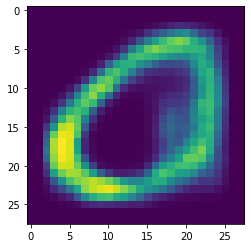

In [41]:
random_latent_z = torch.normal(mean=means, std=std).unsqueeze(0)
print("random latent state {}".format(random_latent_z.detach().numpy()))
reconstructed_image = myVAE.decoder.generate(
    random_latent_z).squeeze(0).detach().numpy()
plt.imshow(reconstructed_image)

# Conclusion

The Variational Autoencoder is a robust and simple method to draw new samples from the distribution of training examples $p(X)$. There are other generative models like Generative Adversarial Networks (GANs) which also allow this.